In [191]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
from numpy import nan
from numpy import isnan
import sklearn as skl
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn import preprocessing
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
import seaborn as sns
from sklearn.model_selection import train_test_split
import sklearn.metrics as metrics
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.pipeline import Pipeline
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from imblearn.ensemble import BalancedRandomForestClassifier
from imblearn.ensemble import RUSBoostClassifier
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import plot_confusion_matrix
from sklearn.preprocessing import LabelBinarizer
from sklearn.linear_model import LassoCV
from imblearn.over_sampling import RandomOverSampler,SMOTE,ADASYN
from fairmlhealth import report, measure, stat_utils
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import classification_report
from collections import Counter
import xgboost
from xgboost import XGBClassifier
import re
from nltk.stem.snowball import SnowballStemmer
import string
import imblearn

import warnings
warnings.filterwarnings("ignore")

In [20]:
def plotOccurence(data,colname,label):
    plot=pd.crosstab(index=data[colname],columns=data[label]).plot(kind='bar',stacked=True,figsize=(16,5))
    plt.xlabel(colname)
    plt.ylabel('Count')
    plt.grid(axis='y',linestyle='-')
    #plt.title(colname+" vs "+label+" count")

In [21]:
def plotProportion(data,colname,label):
    plot=pd.crosstab(index=data[colname],columns=data[label],normalize='index').plot(kind='bar',stacked=True,figsize=(16,5))
    plt.xlabel(colname)
    plt.ylabel('Proportion')
    plt.grid(axis='y',linestyle='-')
    #plt.title(colname+" vs "+label+" proportion")

In [22]:
def plotScatter(data,colname,label):
    plt.scatter(data[colname], data[label], alpha=0.005)
    #plt.yscale('sqrt')
    plt.ylabel(label)
    plt.xlabel(colname)
    plt.title(colname+" vs "+label)
    plt.ylim(1, 50)

In [140]:
def printResults(acc,pre,rec,fs,auc):
    print('Accuracy: %.3f' % acc)
    print('Precision: %.3f' % pre)
    print('Recall: %.3f' % rec)
    print('F1-score: %.3f' % fs)
    print('AUC: %.3f' % auc)

In [157]:
def createModel(trainx,trainy,testx,testy,mode):
    label=1 
    if (mode == 'decision_tree' or mode == 'dt'):
        model = DecisionTreeClassifier()
    elif (mode == 'random_forest' or mode == 'rf'):
        model = RandomForestClassifier(n_estimators=10,max_depth = 5)
    elif (mode == 'balanced_random_forest' or mode == 'brf'):
        model = BalancedRandomForestClassifier(n_estimators=10,max_depth = 5)
    elif (mode == 'adaboost_random_sampling' or mode == 'ars'):
        model = RUSBoostClassifier()  
    elif (mode == 'xg_boost' or mode == 'xgb'):
        model = XGBClassifier(eval_metric='mlogloss') 
    
    fit=model.fit(trainx,trainy)
    predictions=model.predict(testx)
    
    roc=skl.metrics.plot_roc_curve(model,testx,testy)
    predy = pd.DataFrame(fit.predict_proba(testx))
    predy=np.array(predy[1])
    testy1=np.array(testy)
    
    return {
            'accuracy':skl.metrics.accuracy_score(testy, predictions),
            'recall': skl.metrics.recall_score(predictions, testy, pos_label=label),
            'precision':skl.metrics.precision_score(predictions, testy, pos_label=label),
            'f-score':skl.metrics.f1_score(predictions, testy, pos_label=label),
            'AUC':skl.metrics.roc_auc_score(testy1,predy)
           }

In [195]:
def finalModel(trainx,trainy,testx,testy,mode):
    label=1
    
    if (mode == 'xg_boost'):
        model = XGBClassifier(eval_metric='mlogloss')
        
    fit=model.fit(trainx,trainy)
    predictions=model.predict(testx)
    
    roc= skl.metrics.plot_roc_curve(model,testx,testy)
    predy = pd.DataFrame(fit.predict_proba(testx))
    plot_confusion_matrix(model,testx,testy)
    predy=np.array(predy[1])
    testy1=np.array(testy)
    
    return {
            'accuracy':accuracy_score(testy, predictions),
            'recall': recall_score(predictions, testy, pos_label=label),
            'precision':precision_score(predictions, testy, pos_label=label),
            'f-score':f1_score(predictions, testy, pos_label=label),
            'AUC':roc_auc_score(testy1,predy)
           }

In [158]:
def buildAndEvaluateModel(df):
    X = df
    label = 'CHANCE_OF_READMISSION'
    y = X[label]
    kfolds = skl.model_selection.StratifiedKFold(n_splits=10)

   
    for model in ['decision_tree','random_forest','balanced_random_forest','adaboost_random_sampling','xg_boost']:
        accuracy=0
        precision=0
        recall=0
        fscore=0
        auc=0
        for train_mask, test_mask in kfolds.split(X,y):
            train_fold=X.iloc[train_mask]
            test_fold=X.iloc[test_mask]

            trainy=train_fold[label]

            train_fold.drop(columns=label,axis=1,inplace=True)
            trainx=train_fold

            testy=test_fold[label]
            test_fold.drop(columns=label,axis=1,inplace=True)
            testx=test_fold

            result=createModel(trainx,trainy,testx,testy,model)

            accuracy+=result['accuracy']*0.1
            precision+=result['precision']*0.1
            recall+=result['recall']*0.1
            fscore+=result['f-score']*0.1
            auc+=result['AUC']*0.1

        print("Model:",model)
        printResults(accuracy,precision,recall,fscore,auc)
        print()


In [168]:
def buildAndEvaluateModelFinal1(df):
    X = df
    label = 'CHANCE_OF_READMISSION'
    y = X[label]
    kfolds = skl.model_selection.StratifiedKFold(n_splits=10)

    accuracy=0
    precision=0
    recall=0
    fscore=0
    auc=0
    for train_mask, test_mask in kfolds.split(X,y):
        train_fold=X.iloc[train_mask]
        test_fold=X.iloc[test_mask]

        trainy=train_fold[label]

        train_fold.drop(columns=label,axis=1,inplace=True)
        trainx=train_fold

        testy=test_fold[label]
        test_fold.drop(columns=label,axis=1,inplace=True)
        testx=test_fold

        result=finalModel(trainx,trainy,testx,testy)

        accuracy+=result['accuracy']*0.1
        precision+=result['precision']*0.1
        recall+=result['recall']*0.1
        fscore+=result['f-score']*0.1
        auc+=result['AUC']*0.1

    print("Model:",model)
    printResults(accuracy,precision,recall,fscore,auc)
    print()


In [193]:
def buildAndEvaluateModelFinal(df):

    X = df.drop(columns=['CHANCE_OF_READMISSION'])
    y = df['CHANCE_OF_READMISSION']

    # Split into train 80% and test 20%
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .20, random_state = 0)

    model = 'xg_boost'
    result= finalModel(X_train,y_train,X_test,y_test,model)

    accuracy =result['accuracy']
    precision =result['precision']
    recall =result['recall']
    fscore =result['f-score']
    auc =result['AUC']

    print("Model:",model)
    printResults(accuracy,precision,recall,fscore,auc)
    print()

In [141]:
def plotGroupby(data, colname,label):
    ''' 
    Readmission by categorical data 
    '''  
    size = (8,4)
    results = data[[colname, label]].groupby(colname).median().reset_index()
    values = list(results[label].values)
    labels = list(results[colname].values)

    fig, ax = plt.subplots(figsize=size)
    ind = range(len(results))
    ax.barh(ind, values, align='center', height=0.6, color = '#2f5ca5', alpha=0.8)
    ax.set_yticks(ind)
    ax.set_yticklabels(labels)
    ax.set_xlabel('Chance of Readmission')
    ax.tick_params(left=False, top=False, right=False) 
    ax.set_title(colname+" vs "+label)
    
    plt.tight_layout()
    plt.show();

In [26]:
# load data from files
# Hospital admission related info
df_admission = pd.read_csv('data/ADMISSIONS.csv')

df_admission.info();

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58976 entries, 0 to 58975
Data columns (total 19 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   ROW_ID                58976 non-null  int64 
 1   SUBJECT_ID            58976 non-null  int64 
 2   HADM_ID               58976 non-null  int64 
 3   ADMITTIME             58976 non-null  object
 4   DISCHTIME             58976 non-null  object
 5   DEATHTIME             5854 non-null   object
 6   ADMISSION_TYPE        58976 non-null  object
 7   ADMISSION_LOCATION    58976 non-null  object
 8   DISCHARGE_LOCATION    58976 non-null  object
 9   INSURANCE             58976 non-null  object
 10  LANGUAGE              33644 non-null  object
 11  RELIGION              58518 non-null  object
 12  MARITAL_STATUS        48848 non-null  object
 13  ETHNICITY             58976 non-null  object
 14  EDREGTIME             30877 non-null  object
 15  EDOUTTIME             30877 non-null

In [27]:
df_admission.head()

,ROW_ID,SUBJECT_ID,HADM_ID,ADMITTIME,DISCHTIME,DEATHTIME,ADMISSION_TYPE,ADMISSION_LOCATION,DISCHARGE_LOCATION,INSURANCE,LANGUAGE,RELIGION,MARITAL_STATUS,ETHNICITY,EDREGTIME,EDOUTTIME,DIAGNOSIS,HOSPITAL_EXPIRE_FLAG,HAS_CHARTEVENTS_DATA
0,21,22,165315,4/9/2196 12:26,4/10/2196 15:54,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,DISC-TRAN CANCER/CHLDRN H,Private,NaN,UNOBTAINABLE,MARRIED,WHITE,4/9/2196 10:06,4/9/2196 13:24,BENZODIAZEPINE OVERDOSE,0,1
1,22,23,152223,9/3/2153 7:15,9/8/2153 19:10,NaN,ELECTIVE,PHYS REFERRAL/NORMAL DELI,HOME HEALTH CARE,Medicare,NaN,CATHOLIC,MARRIED,WHITE,NaN,NaN,CORONARY ARTERY DISEASE\CORONARY ARTERY BYPASS...,0,1
2,23,23,124321,10/18/2157 19:34,10/25/2157 14:00,NaN,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,HOME HEALTH CARE,Medicare,ENGL,CATHOLIC,MARRIED,WHITE,NaN,NaN,BRAIN MASS,0,1
3,24,24,161859,6/6/2139 16:14,6/9/2139 12:48,NaN,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,HOME,Private,NaN,PROTESTANT QUAKER,SINGLE,WHITE,NaN,NaN,INTERIOR MYOCARDIAL INFARCTION,0,1
4,25,25,129635,11/2/2160 2:06,11/5/2160 14:55,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,HOME,Private,NaN,UNOBTAINABLE,MARRIED,WHITE,11/2/2160 1:01,11/2/2160 4:27,ACUTE CORONARY SYNDROME,0,1


In [28]:
df_admission.drop(columns=['ROW_ID','LANGUAGE','EDREGTIME','EDOUTTIME','HOSPITAL_EXPIRE_FLAG','HAS_CHARTEVENTS_DATA'],inplace = True)

df_admission.head()

,SUBJECT_ID,HADM_ID,ADMITTIME,DISCHTIME,DEATHTIME,ADMISSION_TYPE,ADMISSION_LOCATION,DISCHARGE_LOCATION,INSURANCE,RELIGION,MARITAL_STATUS,ETHNICITY,DIAGNOSIS
0,22,165315,4/9/2196 12:26,4/10/2196 15:54,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,DISC-TRAN CANCER/CHLDRN H,Private,UNOBTAINABLE,MARRIED,WHITE,BENZODIAZEPINE OVERDOSE
1,23,152223,9/3/2153 7:15,9/8/2153 19:10,NaN,ELECTIVE,PHYS REFERRAL/NORMAL DELI,HOME HEALTH CARE,Medicare,CATHOLIC,MARRIED,WHITE,CORONARY ARTERY DISEASE\CORONARY ARTERY BYPASS...
2,23,124321,10/18/2157 19:34,10/25/2157 14:00,NaN,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,HOME HEALTH CARE,Medicare,CATHOLIC,MARRIED,WHITE,BRAIN MASS
3,24,161859,6/6/2139 16:14,6/9/2139 12:48,NaN,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,HOME,Private,PROTESTANT QUAKER,SINGLE,WHITE,INTERIOR MYOCARDIAL INFARCTION
4,25,129635,11/2/2160 2:06,11/5/2160 14:55,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,HOME,Private,UNOBTAINABLE,MARRIED,WHITE,ACUTE CORONARY SYNDROME


In [29]:
# Converting ADMITTIME and DISCHTIME to datatime type
df_admission['ADMITTIME'] = pd.to_datetime(df_admission['ADMITTIME'])
df_admission['DISCHTIME'] = pd.to_datetime(df_admission['DISCHTIME'])

# Get the LOS as number of days from discharge and admit time, 86400 seconds in a day
numSeconds = 24*60*60
df_admission['LOS'] = (df_admission['DISCHTIME'] - df_admission['ADMITTIME']).dt.total_seconds()/numSeconds
#ADMITTIME and DISCHTIME can be dropped
df_admission.head()

,SUBJECT_ID,HADM_ID,ADMITTIME,DISCHTIME,DEATHTIME,ADMISSION_TYPE,ADMISSION_LOCATION,DISCHARGE_LOCATION,INSURANCE,RELIGION,MARITAL_STATUS,ETHNICITY,DIAGNOSIS,LOS
0,22,165315,2196-04-09 12:26:00,2196-04-10 15:54:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,DISC-TRAN CANCER/CHLDRN H,Private,UNOBTAINABLE,MARRIED,WHITE,BENZODIAZEPINE OVERDOSE,1.144444
1,23,152223,2153-09-03 07:15:00,2153-09-08 19:10:00,NaN,ELECTIVE,PHYS REFERRAL/NORMAL DELI,HOME HEALTH CARE,Medicare,CATHOLIC,MARRIED,WHITE,CORONARY ARTERY DISEASE\CORONARY ARTERY BYPASS...,5.496528
2,23,124321,2157-10-18 19:34:00,2157-10-25 14:00:00,NaN,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,HOME HEALTH CARE,Medicare,CATHOLIC,MARRIED,WHITE,BRAIN MASS,6.768056
3,24,161859,2139-06-06 16:14:00,2139-06-09 12:48:00,NaN,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,HOME,Private,PROTESTANT QUAKER,SINGLE,WHITE,INTERIOR MYOCARDIAL INFARCTION,2.856944
4,25,129635,2160-11-02 02:06:00,2160-11-05 14:55:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,HOME,Private,UNOBTAINABLE,MARRIED,WHITE,ACUTE CORONARY SYNDROME,3.534028


In [30]:
df_admission['LOS'].describe()

count    58976.000000
mean        10.133916
std         12.456682
min         -0.945139
25%          3.743750
50%          6.467014
75%         11.795139
max        294.660417
Name: LOS, dtype: float64

In [31]:
df_admission[df_admission.LOS < 0].describe()

,SUBJECT_ID,HADM_ID,LOS
count,98.000000,98.000000,98.000000
mean,30025.785714,152770.336735,-0.290072
std,28055.501190,28955.020962,0.221997
min,181.000000,101946.000000,-0.945139
25%,9270.000000,130047.250000,-0.412500
50%,20731.000000,152006.500000,-0.247222
75%,32360.250000,181287.250000,-0.108681
max,99207.000000,198555.000000,-0.000694


In [32]:
# total 98 rows of -ve LOS which can be dropped
df_admission = df_admission[df_admission['LOS'] >= 0]
df_admission.describe()

,SUBJECT_ID,HADM_ID,LOS
count,58878.000000,58878.000000,58878.000000
mean,33761.791382,149966.149886,10.151266
std,28092.613275,28882.995648,12.459774
min,2.000000,100001.000000,0.001389
25%,11999.250000,124942.750000,3.755556
50%,24141.000000,149987.000000,6.489583
75%,53862.750000,174958.000000,11.805556
max,99999.000000,199999.000000,294.660417


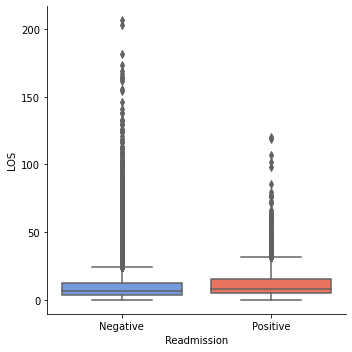

In [120]:
# Create an array with colors
colors = ["#6495ed", "#ff6347"]
# Set custom color palette
sns.set_palette(sns.color_palette(colors))

# create a column for more informative leend plotting
df_admission.loc[df_admission['CHANCE_OF_READMISSION'] == 1, 'Readmission'] = 'Positive'
df_admission.loc[df_admission['CHANCE_OF_READMISSION'] == 0, 'Readmission'] = 'Negative'
# there is no relationship between age and length of stay
sns.catplot(x="Readmission", y="LOS", kind='box', data=df_admission);

In [33]:
# Number of admissions on each admission type
adm_type_num_patients = df_admission.groupby('ADMISSION_TYPE')['HADM_ID'].count()
adm_type_num_patients = adm_type_num_patients.sort_values(ascending = False)
print(adm_type_num_patients)

ADMISSION_TYPE
EMERGENCY    41989
NEWBORN       7854
ELECTIVE      7702
URGENT        1333
Name: HADM_ID, dtype: int64


In [35]:
df_admission = df_admission[df_admission.ADMISSION_TYPE!='NEWBORN']
df_admission = df_admission[df_admission.ADMISSION_TYPE!='ELECTIVE']
print(len(df_admission))

43322


In [36]:
# combine urgent and emergency admissions
df_admission.loc[df_admission['ADMISSION_TYPE']=='URGENT', 'ADMISSION_TYPE'] = 'EMERGENCY'
print(len(df_admission))


43322


In [37]:
# convert ADMIDTIME and DISCHTIME to datetime
df_admission['ADMITTIME'] = pd.to_datetime(df_admission['ADMITTIME'])
df_admission['DISCHTIME'] = pd.to_datetime(df_admission['DISCHTIME'])

# sort by subject_ID and admission date
df_admission = df_admission.sort_values(['SUBJECT_ID','ADMITTIME'])

# Create a column "PREV_DISCHTIME" for date of previous discharge
df_admission['PREV_DISCHTIME'] = df_admission.groupby('SUBJECT_ID').DISCHTIME.shift(1)

In [38]:

# Create a column "NEXT_ADMITTIME" for date of next admission
df_admission['NEXT_ADMITTIME'] = df_admission.groupby('SUBJECT_ID').ADMITTIME.shift(-1)

# create a new calumn calculating the number of days from previous discharge
df_admission['DAYS_FROM_PREV_DICH'] = (df_admission['ADMITTIME'].dt.date-df_admission['PREV_DISCHTIME'].dt.date).dt.days

# create a new calumn calculating the number of days to next admission
df_admission['DAYS_TO_NEXT_ADMIT'] = (df_admission['NEXT_ADMITTIME'].dt.date-df_admission['DISCHTIME'].dt.date).dt.days

# create label CHANCE_OF_READMISSION 0 for not readmitted within 30 days, 1 for readmitted within 30 days
df_admission.loc[df_admission['DAYS_TO_NEXT_ADMIT'] <= 30, 'CHANCE_OF_READMISSION'] = 1
df_admission.loc[df_admission['DAYS_FROM_PREV_DICH'] < 365, '1Y_PRIOR_ADM'] = 1
df_admission['CHANCE_OF_READMISSION'] = df_admission['CHANCE_OF_READMISSION'].fillna(0)
df_admission['1Y_PRIOR_ADM'] = df_admission['1Y_PRIOR_ADM'].fillna(0)
df_admission.head()

,SUBJECT_ID,HADM_ID,ADMITTIME,DISCHTIME,DEATHTIME,ADMISSION_TYPE,ADMISSION_LOCATION,DISCHARGE_LOCATION,INSURANCE,RELIGION,MARITAL_STATUS,ETHNICITY,DIAGNOSIS,LOS,PREV_DISCHTIME,NEXT_ADMITTIME,DAYS_FROM_PREV_DICH,DAYS_TO_NEXT_ADMIT,CHANCE_OF_READMISSION,1Y_PRIOR_ADM
212,3,145834,2101-10-20 19:08:00,2101-10-31 13:58:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,SNF,Medicare,CATHOLIC,MARRIED,WHITE,HYPOTENSION,10.784722,NaT,NaT,NaN,NaN,0.0,0.0
213,4,185777,2191-03-16 00:28:00,2191-03-23 18:41:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,HOME WITH HOME IV PROVIDR,Private,PROTESTANT QUAKER,SINGLE,WHITE,"FEVER,DEHYDRATION,FAILURE TO THRIVE",7.759028,NaT,NaT,NaN,NaN,0.0,0.0
218,9,150750,2149-11-09 13:06:00,2149-11-14 10:15:00,11/14/2149 10:15,EMERGENCY,EMERGENCY ROOM ADMIT,DEAD/EXPIRED,Medicaid,UNOBTAINABLE,NaN,UNKNOWN/NOT SPECIFIED,HEMORRHAGIC CVA,4.881250,NaT,NaT,NaN,NaN,0.0,0.0
220,11,194540,2178-04-16 06:18:00,2178-05-11 19:00:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,HOME HEALTH CARE,Private,OTHER,MARRIED,WHITE,BRAIN MASS,25.529167,NaT,NaT,NaN,NaN,0.0,0.0
222,13,143045,2167-01-08 18:43:00,2167-01-15 15:15:00,NaN,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,HOME HEALTH CARE,Medicaid,OTHER,NaN,WHITE,CORONARY ARTERY DISEASE,6.855556,NaT,NaT,NaN,NaN,0.0,0.0


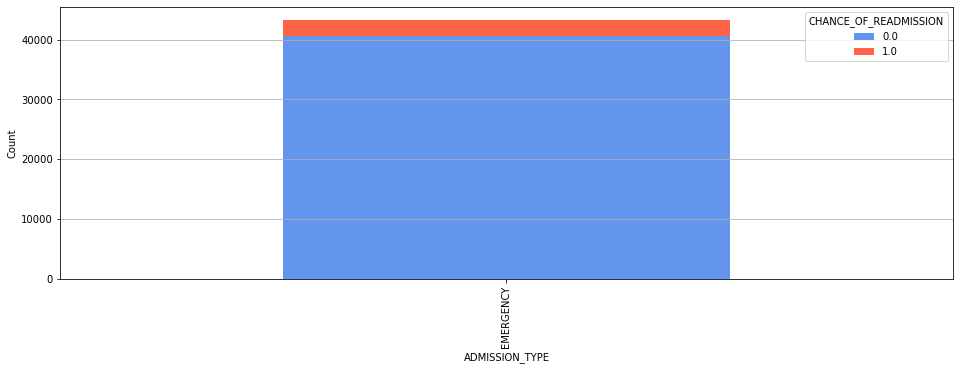

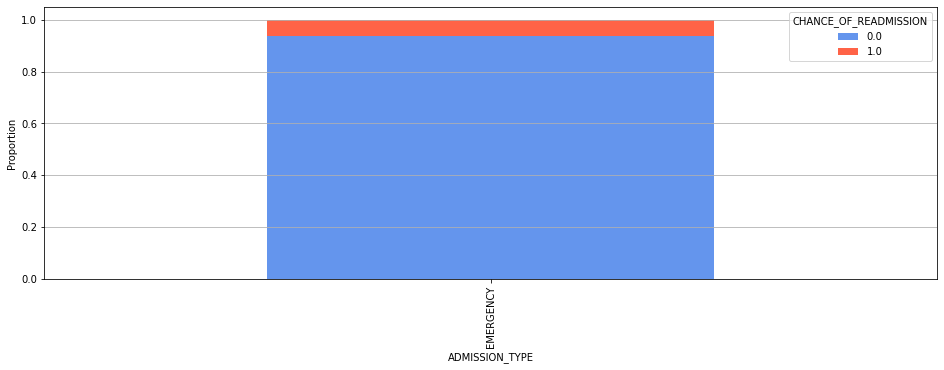

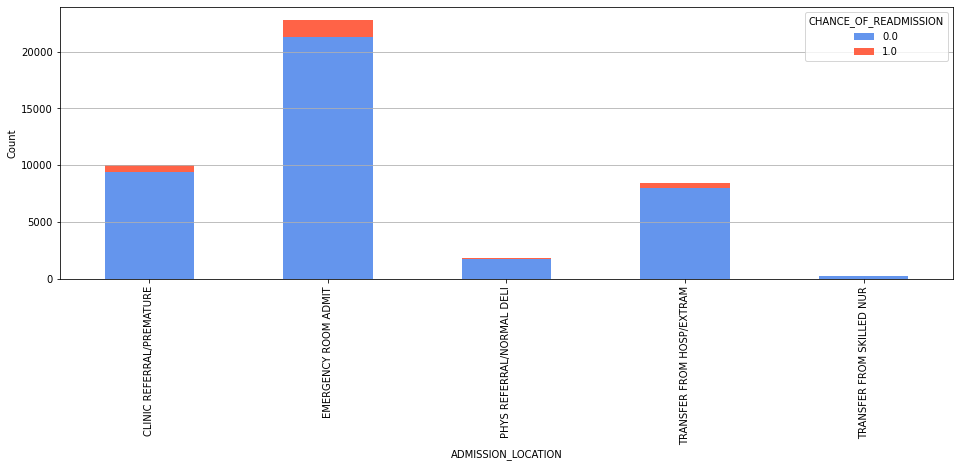

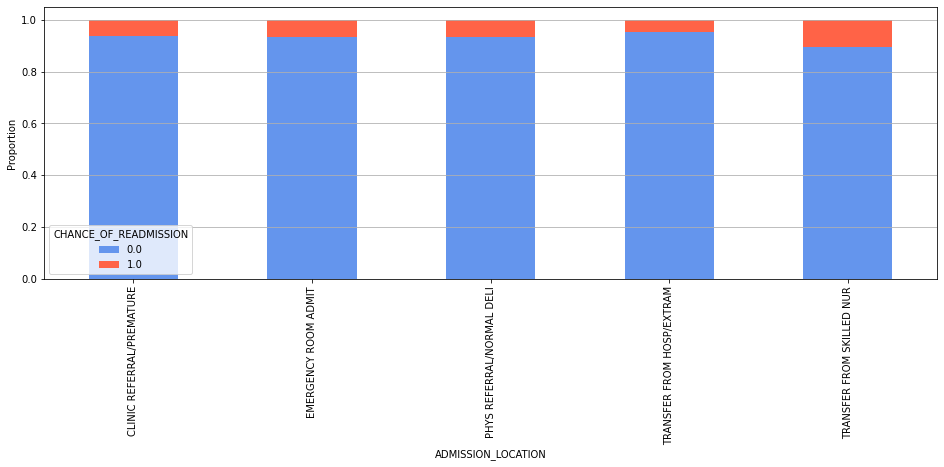

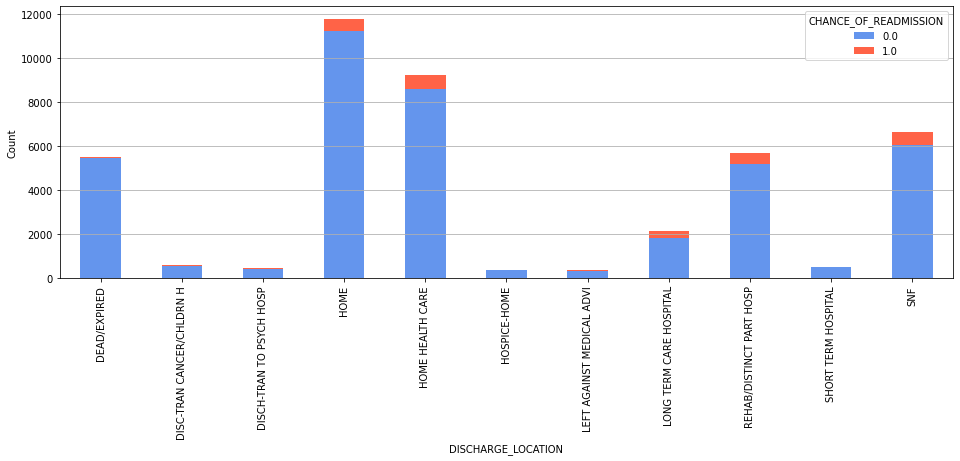

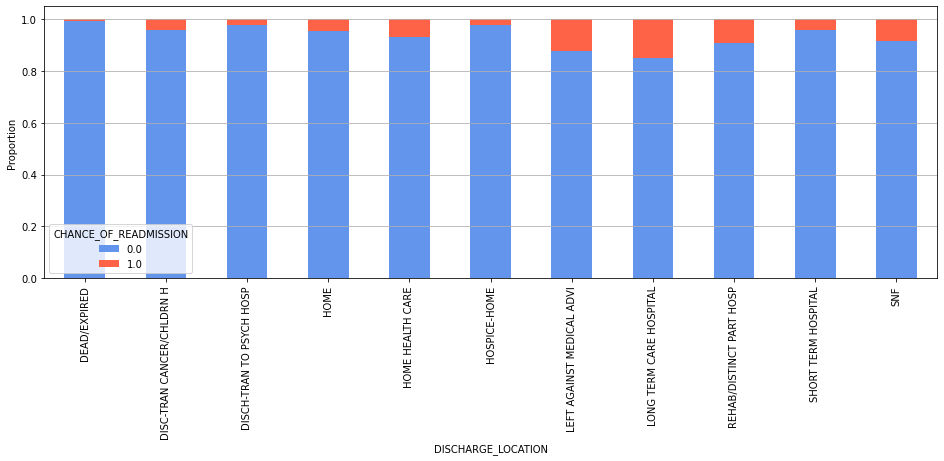

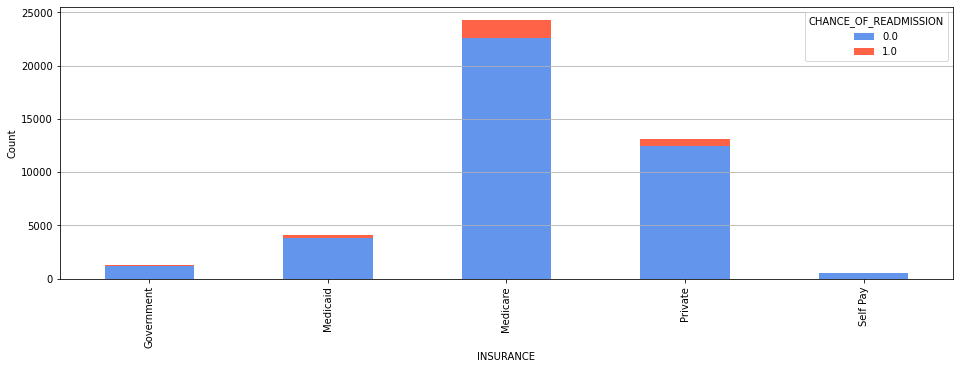

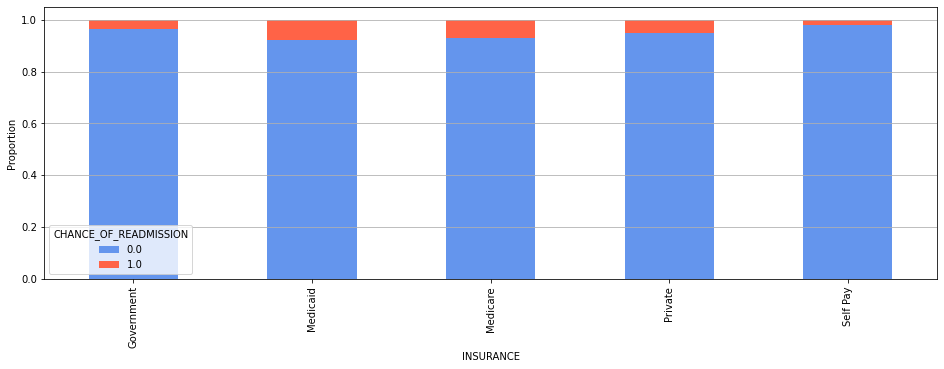

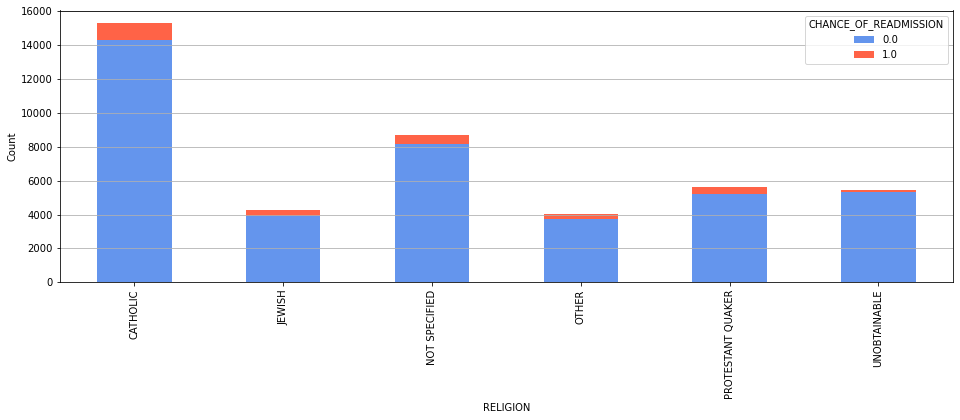

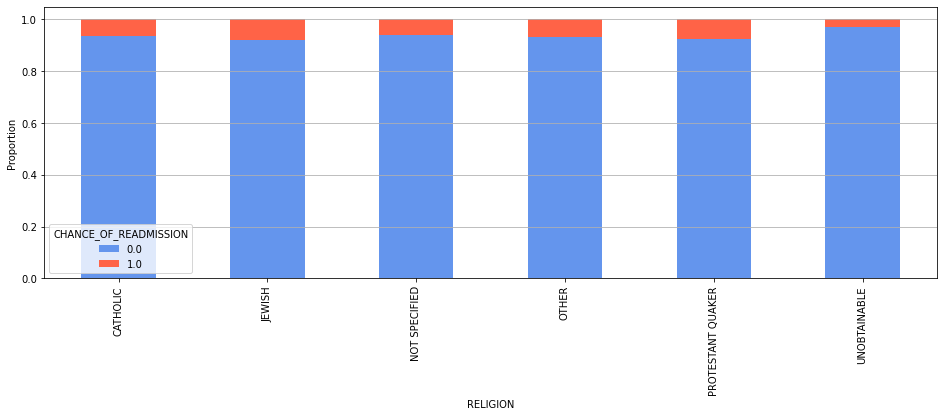

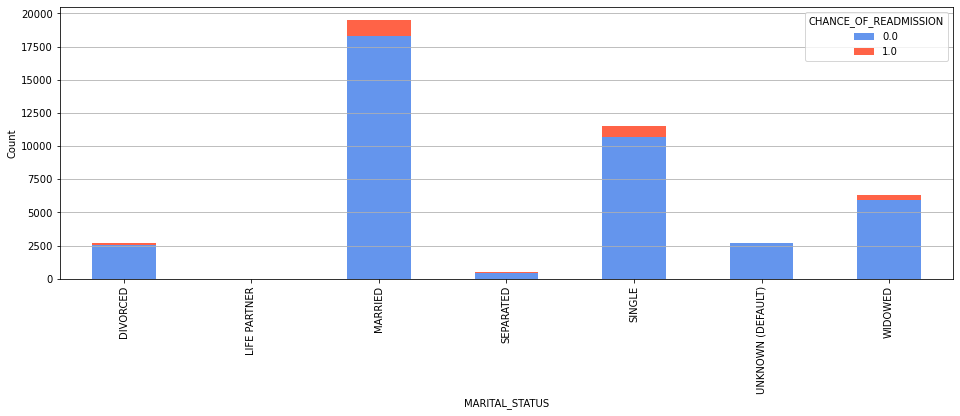

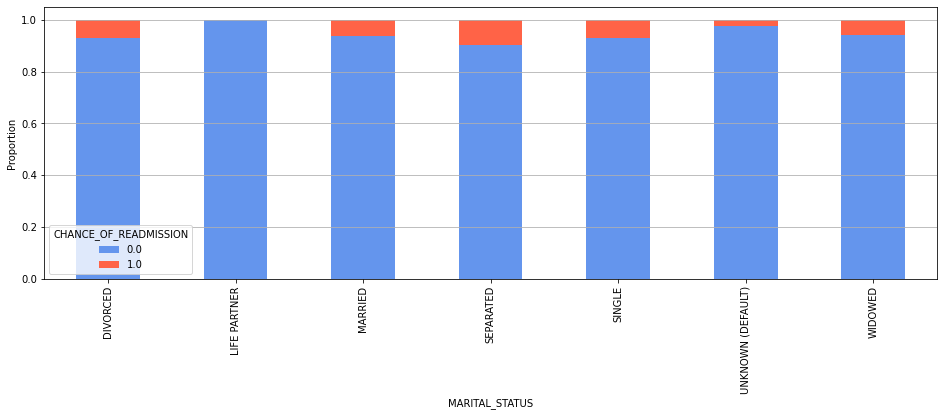

In [125]:
labels=['ADMISSION_TYPE','ADMISSION_LOCATION','DISCHARGE_LOCATION','INSURANCE','RELIGION','MARITAL_STATUS']
for label in labels:
    plotOccurence(df_admission,label,'CHANCE_OF_READMISSION')
    plotProportion(df_admission,label,'CHANCE_OF_READMISSION')

In [39]:
print(df_admission.ADMISSION_LOCATION.value_counts())

EMERGENCY ROOM ADMIT         22712
CLINIC REFERRAL/PREMATURE    10005
TRANSFER FROM HOSP/EXTRAM     8399
PHYS REFERRAL/NORMAL DELI     1869
TRANSFER FROM SKILLED NUR      259
TRANSFER FROM OTHER HEALT       68
TRSF WITHIN THIS FACILITY        5
** INFO NOT AVAILABLE **         4
HMO REFERRAL/SICK                1
Name: ADMISSION_LOCATION, dtype: int64


In [40]:
# Merge categories with less number of samples into the largest category
df_admission.loc[df_admission['ADMISSION_LOCATION']=='** INFO NOT AVAILABLE **', 'ADMISSION_LOCATION']='EMERGENCY ROOM ADMIT'
df_admission.loc[df_admission['ADMISSION_LOCATION']=='HMO REFERRAL/SICK', 'ADMISSION_LOCATION']='EMERGENCY ROOM ADMIT'
df_admission.loc[df_admission['ADMISSION_LOCATION']=='TRANSFER FROM OTHER HEALT', 'ADMISSION_LOCATION']='EMERGENCY ROOM ADMIT'
df_admission.loc[df_admission['ADMISSION_LOCATION']=='TRSF WITHIN THIS FACILITY', 'ADMISSION_LOCATION']='EMERGENCY ROOM ADMIT'
print(df_admission.ADMISSION_LOCATION.value_counts())

EMERGENCY ROOM ADMIT         22790
CLINIC REFERRAL/PREMATURE    10005
TRANSFER FROM HOSP/EXTRAM     8399
PHYS REFERRAL/NORMAL DELI     1869
TRANSFER FROM SKILLED NUR      259
Name: ADMISSION_LOCATION, dtype: int64


In [41]:
print(df_admission.DISCHARGE_LOCATION.value_counts())

HOME                         11456
HOME HEALTH CARE              9231
SNF                           6631
REHAB/DISTINCT PART HOSP      5712
DEAD/EXPIRED                  5520
LONG TERM CARE HOSPITAL       2148
DISC-TRAN CANCER/CHLDRN H      601
SHORT TERM HOSPITAL            508
DISCH-TRAN TO PSYCH HOSP       446
HOSPICE-HOME                   392
LEFT AGAINST MEDICAL ADVI      351
HOSPICE-MEDICAL FACILITY       150
HOME WITH HOME IV PROVIDR       59
OTHER FACILITY                  59
ICF                             47
DISC-TRAN TO FEDERAL HC         10
SNF-MEDICAID ONLY CERTIF         1
Name: DISCHARGE_LOCATION, dtype: int64


In [42]:
# merge categories with less samples
df_admission.loc[df_admission['DISCHARGE_LOCATION']=='DISC-TRAN TO FEDERAL HC', 'DISCHARGE_LOCATION']='HOME'
df_admission.loc[df_admission['DISCHARGE_LOCATION']=='HOME WITH HOME IV PROVIDR', 'DISCHARGE_LOCATION']='HOME'
df_admission.loc[df_admission['DISCHARGE_LOCATION']=='HOSPICE-MEDICAL FACILITY', 'DISCHARGE_LOCATION']='HOME'
df_admission.loc[df_admission['DISCHARGE_LOCATION']=='ICF', 'DISCHARGE_LOCATION']='HOME'
df_admission.loc[df_admission['DISCHARGE_LOCATION']=='OTHER FACILITY', 'DISCHARGE_LOCATION']='HOME'
df_admission.loc[df_admission['DISCHARGE_LOCATION']=='SNF-MEDICAID ONLY CERTIF', 'DISCHARGE_LOCATION']='HOME'
print(df_admission.DISCHARGE_LOCATION.value_counts())

HOME                         11782
HOME HEALTH CARE              9231
SNF                           6631
REHAB/DISTINCT PART HOSP      5712
DEAD/EXPIRED                  5520
LONG TERM CARE HOSPITAL       2148
DISC-TRAN CANCER/CHLDRN H      601
SHORT TERM HOSPITAL            508
DISCH-TRAN TO PSYCH HOSP       446
HOSPICE-HOME                   392
LEFT AGAINST MEDICAL ADVI      351
Name: DISCHARGE_LOCATION, dtype: int64


In [43]:
df_admission['ETHNICITY'].value_counts(dropna=False)

WHITE                                                       30252
BLACK/AFRICAN AMERICAN                                       4224
UNKNOWN/NOT SPECIFIED                                        3535
HISPANIC OR LATINO                                           1169
OTHER                                                         961
UNABLE TO OBTAIN                                              697
ASIAN                                                         695
PATIENT DECLINED TO ANSWER                                    296
HISPANIC/LATINO - PUERTO RICAN                                204
ASIAN - CHINESE                                               189
BLACK/CAPE VERDEAN                                            148
WHITE - RUSSIAN                                               145
BLACK/HAITIAN                                                  93
MULTI RACE ETHNICITY                                           89
ASIAN - ASIAN INDIAN                                           66
HISPANIC/L

In [44]:
# Reducing the number of ETHNICITY categories

df_admission['ETHNICITY'].replace(regex=r'^ASIAN\D*', value='ASIAN', inplace=True)
df_admission['ETHNICITY'].replace(regex=r'^WHITE\D*', value='WHITE', inplace=True)
df_admission['ETHNICITY'].replace(regex=r'^HISPANIC\D*', value='HISPANIC', inplace=True)
df_admission['ETHNICITY'].replace(regex=r'^BLACK\D*', value='BLACK', inplace=True)
df_admission['ETHNICITY'].replace(['UNABLE TO OBTAIN', 'OTHER', 'PATIENT DECLINED TO ANSWER', 
                         'UNKNOWN/NOT SPECIFIED'], value='OTHER', inplace=True)
df_admission['ETHNICITY'].loc[~df_admission['ETHNICITY'].isin(df_admission['ETHNICITY'].value_counts().nlargest(5).index.tolist())] = 'OTHER'
df_admission['ETHNICITY'].value_counts()

WHITE       30507
OTHER        5715
BLACK        4502
HISPANIC     1541
ASIAN        1057
Name: ETHNICITY, dtype: int64

In [45]:
df_admission['RELIGION'].value_counts(dropna=False)

CATHOLIC                  15275
NOT SPECIFIED              8700
PROTESTANT QUAKER          5620
UNOBTAINABLE               5037
JEWISH                     4241
OTHER                      2087
EPISCOPALIAN                573
NaN                         425
GREEK ORTHODOX              364
CHRISTIAN SCIENTIST         260
BUDDHIST                    174
MUSLIM                      161
JEHOVAH'S WITNESS           110
UNITARIAN-UNIVERSALIST       80
7TH DAY ADVENTIST            62
ROMANIAN EAST. ORTH          57
HINDU                        52
BAPTIST                      23
HEBREW                       15
METHODIST                     5
LUTHERAN                      1
Name: RELIGION, dtype: int64

In [46]:
df_admission['RELIGION'] = df_admission['RELIGION'].fillna('UNOBTAINABLE')
df_admission['RELIGION'].replace(['EPISCOPALIAN', 'GREEK ORTHODOX', 'CHRISTIAN SCIENTIST','BUDDHIST','MUSLIM','JEHOVAH\'S WITNESS', 
                       'UNITARIAN-UNIVERSALIST','HINDU','ROMANIAN EAST. ORTH','7TH DAY ADVENTIST','BAPTIST','HEBREW','METHODIST','LUTHERAN','BUDDHIST'], value='OTHER', inplace=True)
df_admission['RELIGION'].value_counts()

CATHOLIC             15275
NOT SPECIFIED         8700
PROTESTANT QUAKER     5620
UNOBTAINABLE          5462
JEWISH                4241
OTHER                 4024
Name: RELIGION, dtype: int64

In [47]:
df_admission['INSURANCE'].value_counts(dropna=False)

Medicare      24292
Private       13095
Medicaid       4129
Government     1256
Self Pay        550
Name: INSURANCE, dtype: int64

In [48]:
df_admission['MARITAL_STATUS'].value_counts(dropna=False)

MARRIED              19507
SINGLE               11537
WIDOWED               6335
DIVORCED              2702
NaN                   2423
SEPARATED              497
UNKNOWN (DEFAULT)      308
LIFE PARTNER            13
Name: MARITAL_STATUS, dtype: int64

In [49]:
df_admission['MARITAL_STATUS'] = df_admission['MARITAL_STATUS'].fillna('UNKNOWN (DEFAULT)')
df_admission['MARITAL_STATUS'].value_counts(dropna=False)

MARRIED              19507
SINGLE               11537
WIDOWED               6335
UNKNOWN (DEFAULT)     2731
DIVORCED              2702
SEPARATED              497
LIFE PARTNER            13
Name: MARITAL_STATUS, dtype: int64

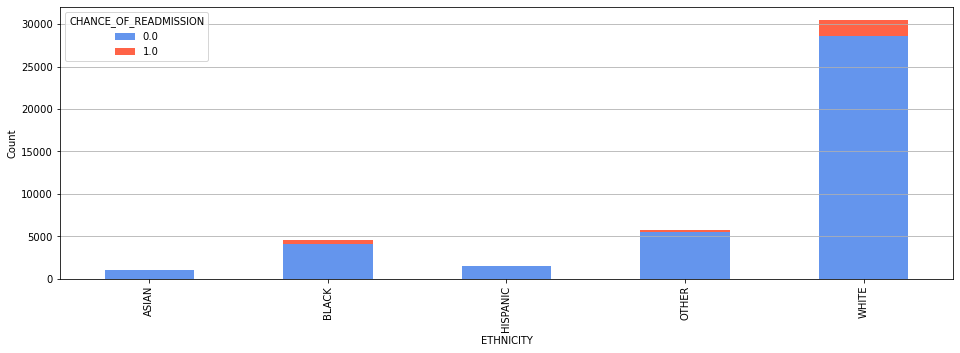

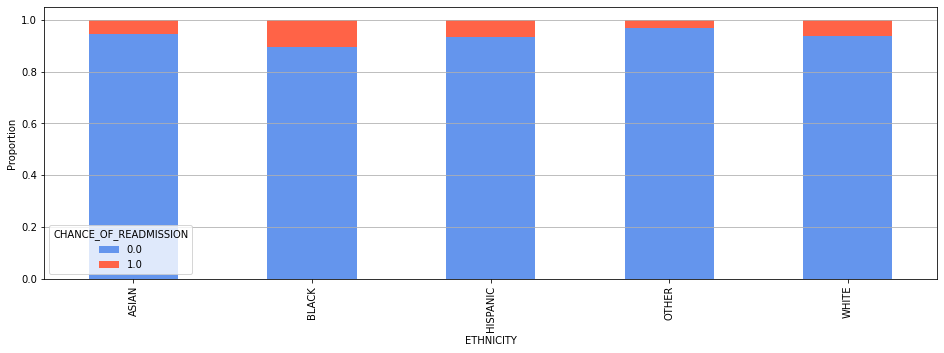

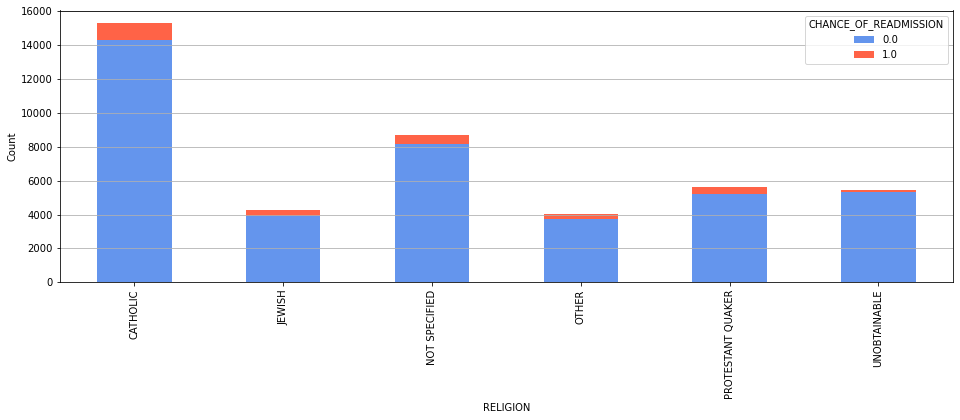

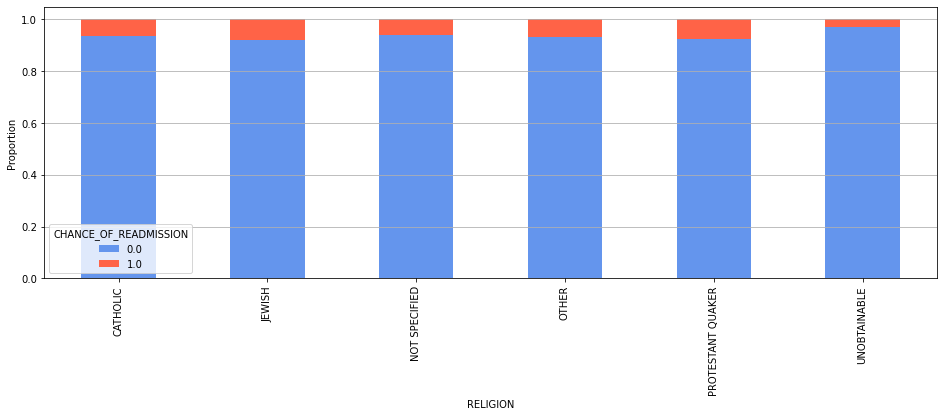

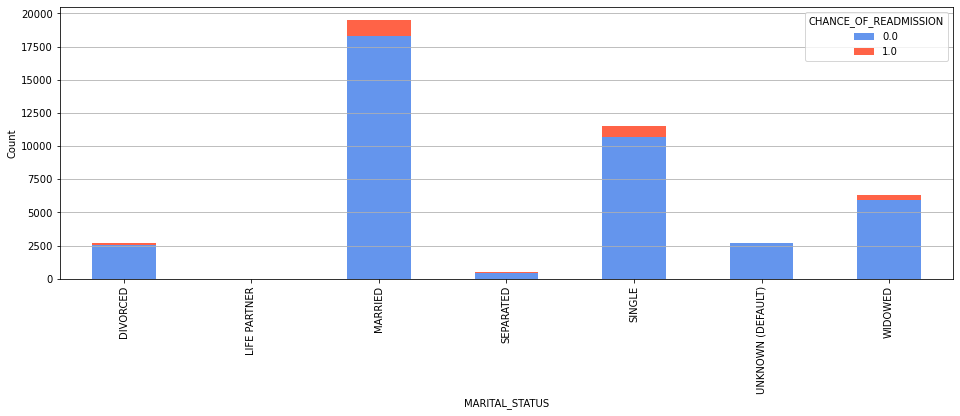

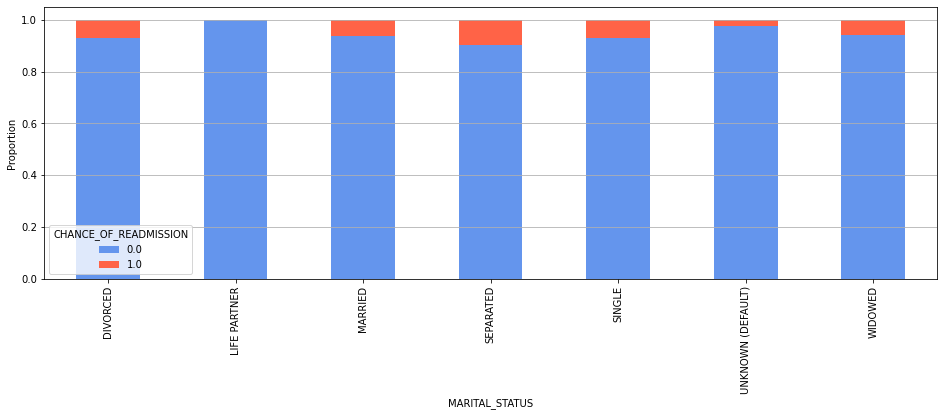

In [127]:
labels=['ETHNICITY','RELIGION','MARITAL_STATUS']
for label in labels:
    plotOccurence(df_admission,label,'CHANCE_OF_READMISSION')
    plotProportion(df_admission,label,'CHANCE_OF_READMISSION')

In [50]:
# Load Patient's info
df_patient = pd.read_csv('data/PATIENTS.csv')
df_patient.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46520 entries, 0 to 46519
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   ROW_ID       46520 non-null  int64 
 1   SUBJECT_ID   46520 non-null  int64 
 2   GENDER       46520 non-null  object
 3   DOB          46520 non-null  object
 4   DOD          15759 non-null  object
 5   DOD_HOSP     9974 non-null   object
 6   DOD_SSN      13378 non-null  object
 7   EXPIRE_FLAG  46520 non-null  int64 
dtypes: int64(3), object(5)
memory usage: 2.8+ MB


In [51]:
df_patient.head()

,ROW_ID,SUBJECT_ID,GENDER,DOB,DOD,DOD_HOSP,DOD_SSN,EXPIRE_FLAG
0,234,249,F,2075-03-13 00:00:00,NaN,NaN,NaN,0
1,235,250,F,2164-12-27 00:00:00,2188-11-22 00:00:00,2188-11-22 00:00:00,NaN,1
2,236,251,M,2090-03-15 00:00:00,NaN,NaN,NaN,0
3,237,252,M,2078-03-06 00:00:00,NaN,NaN,NaN,0
4,238,253,F,2089-11-26 00:00:00,NaN,NaN,NaN,0


In [52]:
df_patient.drop(columns=['ROW_ID','DOD','DOD_HOSP','DOD_SSN','EXPIRE_FLAG'],inplace = True)


In [53]:
df_patient['GENDER'].value_counts(dropna=False)

M    26121
F    20399
Name: GENDER, dtype: int64

In [54]:
# To Convert DOB to datetime type
df_patient['DOB'] = pd.to_datetime(df_patient['DOB'])
df_patient.head()

,SUBJECT_ID,GENDER,DOB
0,249,F,2075-03-13
1,250,F,2164-12-27
2,251,M,2090-03-15
3,252,M,2078-03-06
4,253,F,2089-11-26


In [55]:
df_admission = df_admission.merge(df_patient, how='inner', on='SUBJECT_ID')
df_admission.head()

,SUBJECT_ID,HADM_ID,ADMITTIME,DISCHTIME,DEATHTIME,ADMISSION_TYPE,ADMISSION_LOCATION,DISCHARGE_LOCATION,INSURANCE,RELIGION,...,DIAGNOSIS,LOS,PREV_DISCHTIME,NEXT_ADMITTIME,DAYS_FROM_PREV_DICH,DAYS_TO_NEXT_ADMIT,CHANCE_OF_READMISSION,1Y_PRIOR_ADM,GENDER,DOB
0,3,145834,2101-10-20 19:08:00,2101-10-31 13:58:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,SNF,Medicare,CATHOLIC,...,HYPOTENSION,10.784722,NaT,NaT,NaN,NaN,0.0,0.0,M,2025-04-11
1,4,185777,2191-03-16 00:28:00,2191-03-23 18:41:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,HOME,Private,PROTESTANT QUAKER,...,"FEVER,DEHYDRATION,FAILURE TO THRIVE",7.759028,NaT,NaT,NaN,NaN,0.0,0.0,F,2143-05-12
2,9,150750,2149-11-09 13:06:00,2149-11-14 10:15:00,11/14/2149 10:15,EMERGENCY,EMERGENCY ROOM ADMIT,DEAD/EXPIRED,Medicaid,UNOBTAINABLE,...,HEMORRHAGIC CVA,4.881250,NaT,NaT,NaN,NaN,0.0,0.0,M,2108-01-26
3,11,194540,2178-04-16 06:18:00,2178-05-11 19:00:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,HOME HEALTH CARE,Private,OTHER,...,BRAIN MASS,25.529167,NaT,NaT,NaN,NaN,0.0,0.0,F,2128-02-22
4,13,143045,2167-01-08 18:43:00,2167-01-15 15:15:00,NaN,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,HOME HEALTH CARE,Medicaid,OTHER,...,CORONARY ARTERY DISEASE,6.855556,NaT,NaT,NaN,NaN,0.0,0.0,F,2127-02-27


In [56]:
# Find the first admission time for each patient to calculate the age
df_admission_age_patient = df_admission[['SUBJECT_ID', 'ADMITTIME']].groupby('SUBJECT_ID').min().reset_index()
df_admission_age_patient.columns = ['SUBJECT_ID', 'FIRST_ADMITTIME']
df_admission_age_patient.head()

,SUBJECT_ID,FIRST_ADMITTIME
0,3,2101-10-20 19:08:00
1,4,2191-03-16 00:28:00
2,9,2149-11-09 13:06:00
3,11,2178-04-16 06:18:00
4,13,2167-01-08 18:43:00


In [57]:
df_admission = df_admission.merge(df_admission_age_patient, how='outer', on='SUBJECT_ID')
df_admission.head()

,SUBJECT_ID,HADM_ID,ADMITTIME,DISCHTIME,DEATHTIME,ADMISSION_TYPE,ADMISSION_LOCATION,DISCHARGE_LOCATION,INSURANCE,RELIGION,...,LOS,PREV_DISCHTIME,NEXT_ADMITTIME,DAYS_FROM_PREV_DICH,DAYS_TO_NEXT_ADMIT,CHANCE_OF_READMISSION,1Y_PRIOR_ADM,GENDER,DOB,FIRST_ADMITTIME
0,3,145834,2101-10-20 19:08:00,2101-10-31 13:58:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,SNF,Medicare,CATHOLIC,...,10.784722,NaT,NaT,NaN,NaN,0.0,0.0,M,2025-04-11,2101-10-20 19:08:00
1,4,185777,2191-03-16 00:28:00,2191-03-23 18:41:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,HOME,Private,PROTESTANT QUAKER,...,7.759028,NaT,NaT,NaN,NaN,0.0,0.0,F,2143-05-12,2191-03-16 00:28:00
2,9,150750,2149-11-09 13:06:00,2149-11-14 10:15:00,11/14/2149 10:15,EMERGENCY,EMERGENCY ROOM ADMIT,DEAD/EXPIRED,Medicaid,UNOBTAINABLE,...,4.881250,NaT,NaT,NaN,NaN,0.0,0.0,M,2108-01-26,2149-11-09 13:06:00
3,11,194540,2178-04-16 06:18:00,2178-05-11 19:00:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,HOME HEALTH CARE,Private,OTHER,...,25.529167,NaT,NaT,NaN,NaN,0.0,0.0,F,2128-02-22,2178-04-16 06:18:00
4,13,143045,2167-01-08 18:43:00,2167-01-15 15:15:00,NaN,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,HOME HEALTH CARE,Medicaid,OTHER,...,6.855556,NaT,NaT,NaN,NaN,0.0,0.0,F,2127-02-27,2167-01-08 18:43:00


In [58]:
# Age is calculated as subtracting DOB from FIRST_ADMITTIME and divided by 365 

df_admission['FIRST_ADMITTIME'] = pd.to_datetime(df_admission['FIRST_ADMITTIME']).dt.date

df_admission['DOB'] = pd.to_datetime(df_admission['DOB']).dt.date

# since for patients above 89 years shifted the 'DOB' 300 years
df_admission['AGE'] = df_admission.apply(lambda e: (e['FIRST_ADMITTIME'] - e['DOB']).days/365, axis=1)

df_admission.head()

,SUBJECT_ID,HADM_ID,ADMITTIME,DISCHTIME,DEATHTIME,ADMISSION_TYPE,ADMISSION_LOCATION,DISCHARGE_LOCATION,INSURANCE,RELIGION,...,PREV_DISCHTIME,NEXT_ADMITTIME,DAYS_FROM_PREV_DICH,DAYS_TO_NEXT_ADMIT,CHANCE_OF_READMISSION,1Y_PRIOR_ADM,GENDER,DOB,FIRST_ADMITTIME,AGE
0,3,145834,2101-10-20 19:08:00,2101-10-31 13:58:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,SNF,Medicare,CATHOLIC,...,NaT,NaT,NaN,NaN,0.0,0.0,M,2025-04-11,2101-10-20,76.575342
1,4,185777,2191-03-16 00:28:00,2191-03-23 18:41:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,HOME,Private,PROTESTANT QUAKER,...,NaT,NaT,NaN,NaN,0.0,0.0,F,2143-05-12,2191-03-16,47.876712
2,9,150750,2149-11-09 13:06:00,2149-11-14 10:15:00,11/14/2149 10:15,EMERGENCY,EMERGENCY ROOM ADMIT,DEAD/EXPIRED,Medicaid,UNOBTAINABLE,...,NaT,NaT,NaN,NaN,0.0,0.0,M,2108-01-26,2149-11-09,41.816438
3,11,194540,2178-04-16 06:18:00,2178-05-11 19:00:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,HOME HEALTH CARE,Private,OTHER,...,NaT,NaT,NaN,NaN,0.0,0.0,F,2128-02-22,2178-04-16,50.180822
4,13,143045,2167-01-08 18:43:00,2167-01-15 15:15:00,NaN,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,HOME HEALTH CARE,Medicaid,OTHER,...,NaT,NaT,NaN,NaN,0.0,0.0,F,2127-02-27,2167-01-08,39.890411


In [59]:
df_admission['AGE'].describe()

count    43322.000000
mean        75.314821
std         58.267668
min          0.000000
25%         51.465753
50%         65.249315
75%         78.049315
max        310.216438
Name: AGE, dtype: float64

In [60]:
df_admission['AGE'] = np.where(df_admission['AGE'] < 0, 0, df_admission['AGE'])
df_admission['AGE'] = np.where(df_admission['AGE'] > 100,100, df_admission['AGE'])
df_admission['AGE'].describe()

count    43322.000000
mean        63.755582
std         19.397558
min          0.000000
25%         51.465753
50%         65.249315
75%         78.049315
max        100.000000
Name: AGE, dtype: float64

In [61]:
# Create age categories
age_ranges = [(0, 13), (13, 26), (26, 46), (46, 66),(66,81),(81,100)]
for num, cat_range in enumerate(age_ranges):
    df_admission['AGE'] = np.where(df_admission['AGE'].between(cat_range[0],cat_range[1]), 
            num, df_admission['AGE'])
age_cat = {0: 'young_child', 1: 'youth', 2: 'adult', 3: 'middle_adult', 4:'senior_adult', 5:'oldage'}
df_admission['AGE'] = df_admission['AGE'].replace(age_cat)

In [62]:
df_admission.head()

,SUBJECT_ID,HADM_ID,ADMITTIME,DISCHTIME,DEATHTIME,ADMISSION_TYPE,ADMISSION_LOCATION,DISCHARGE_LOCATION,INSURANCE,RELIGION,...,PREV_DISCHTIME,NEXT_ADMITTIME,DAYS_FROM_PREV_DICH,DAYS_TO_NEXT_ADMIT,CHANCE_OF_READMISSION,1Y_PRIOR_ADM,GENDER,DOB,FIRST_ADMITTIME,AGE
0,3,145834,2101-10-20 19:08:00,2101-10-31 13:58:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,SNF,Medicare,CATHOLIC,...,NaT,NaT,NaN,NaN,0.0,0.0,M,2025-04-11,2101-10-20,senior_adult
1,4,185777,2191-03-16 00:28:00,2191-03-23 18:41:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,HOME,Private,PROTESTANT QUAKER,...,NaT,NaT,NaN,NaN,0.0,0.0,F,2143-05-12,2191-03-16,middle_adult
2,9,150750,2149-11-09 13:06:00,2149-11-14 10:15:00,11/14/2149 10:15,EMERGENCY,EMERGENCY ROOM ADMIT,DEAD/EXPIRED,Medicaid,UNOBTAINABLE,...,NaT,NaT,NaN,NaN,0.0,0.0,M,2108-01-26,2149-11-09,adult
3,11,194540,2178-04-16 06:18:00,2178-05-11 19:00:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,HOME HEALTH CARE,Private,OTHER,...,NaT,NaT,NaN,NaN,0.0,0.0,F,2128-02-22,2178-04-16,middle_adult
4,13,143045,2167-01-08 18:43:00,2167-01-15 15:15:00,NaN,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,HOME HEALTH CARE,Medicaid,OTHER,...,NaT,NaT,NaN,NaN,0.0,0.0,F,2127-02-27,2167-01-08,adult


In [64]:
enc= preprocessing.LabelEncoder()
df_admission['GENDER'] = pd.Series(enc.fit_transform(df_admission.GENDER.astype('str')))

In [65]:
df_admission.head()

,SUBJECT_ID,HADM_ID,ADMITTIME,DISCHTIME,DEATHTIME,ADMISSION_TYPE,ADMISSION_LOCATION,DISCHARGE_LOCATION,INSURANCE,RELIGION,...,PREV_DISCHTIME,NEXT_ADMITTIME,DAYS_FROM_PREV_DICH,DAYS_TO_NEXT_ADMIT,CHANCE_OF_READMISSION,1Y_PRIOR_ADM,GENDER,DOB,FIRST_ADMITTIME,AGE
0,3,145834,2101-10-20 19:08:00,2101-10-31 13:58:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,SNF,Medicare,CATHOLIC,...,NaT,NaT,NaN,NaN,0.0,0.0,1,2025-04-11,2101-10-20,senior_adult
1,4,185777,2191-03-16 00:28:00,2191-03-23 18:41:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,HOME,Private,PROTESTANT QUAKER,...,NaT,NaT,NaN,NaN,0.0,0.0,0,2143-05-12,2191-03-16,middle_adult
2,9,150750,2149-11-09 13:06:00,2149-11-14 10:15:00,11/14/2149 10:15,EMERGENCY,EMERGENCY ROOM ADMIT,DEAD/EXPIRED,Medicaid,UNOBTAINABLE,...,NaT,NaT,NaN,NaN,0.0,0.0,1,2108-01-26,2149-11-09,adult
3,11,194540,2178-04-16 06:18:00,2178-05-11 19:00:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,HOME HEALTH CARE,Private,OTHER,...,NaT,NaT,NaN,NaN,0.0,0.0,0,2128-02-22,2178-04-16,middle_adult
4,13,143045,2167-01-08 18:43:00,2167-01-15 15:15:00,NaN,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,HOME HEALTH CARE,Medicaid,OTHER,...,NaT,NaT,NaN,NaN,0.0,0.0,0,2127-02-27,2167-01-08,adult


In [66]:
df_admission['CHANCE_OF_READMISSION'].value_counts(dropna=False)

0.0    40612
1.0     2710
Name: CHANCE_OF_READMISSION, dtype: int64

In [67]:
# Create dummy columns for categorical variables
col_pref = ['ADMSNT', 'INSR', 'RELGN', 'ETHN', 'MS','AG','ADMSNL','DISCHL']
dummy_cols = ['ADMISSION_TYPE', 'INSURANCE', 'RELIGION',
             'ETHNICITY', 'MARITAL_STATUS','AGE','ADMISSION_LOCATION','DISCHARGE_LOCATION']
df = pd.get_dummies(df_admission, prefix=col_pref, columns=dummy_cols)
df.head()

,SUBJECT_ID,HADM_ID,ADMITTIME,DISCHTIME,DEATHTIME,DIAGNOSIS,LOS,PREV_DISCHTIME,NEXT_ADMITTIME,DAYS_FROM_PREV_DICH,...,DISCHL_DISC-TRAN CANCER/CHLDRN H,DISCHL_DISCH-TRAN TO PSYCH HOSP,DISCHL_HOME,DISCHL_HOME HEALTH CARE,DISCHL_HOSPICE-HOME,DISCHL_LEFT AGAINST MEDICAL ADVI,DISCHL_LONG TERM CARE HOSPITAL,DISCHL_REHAB/DISTINCT PART HOSP,DISCHL_SHORT TERM HOSPITAL,DISCHL_SNF
0,3,145834,2101-10-20 19:08:00,2101-10-31 13:58:00,NaN,HYPOTENSION,10.784722,NaT,NaT,NaN,...,0,0,0,0,0,0,0,0,0,1
1,4,185777,2191-03-16 00:28:00,2191-03-23 18:41:00,NaN,"FEVER,DEHYDRATION,FAILURE TO THRIVE",7.759028,NaT,NaT,NaN,...,0,0,1,0,0,0,0,0,0,0
2,9,150750,2149-11-09 13:06:00,2149-11-14 10:15:00,11/14/2149 10:15,HEMORRHAGIC CVA,4.881250,NaT,NaT,NaN,...,0,0,0,0,0,0,0,0,0,0
3,11,194540,2178-04-16 06:18:00,2178-05-11 19:00:00,NaN,BRAIN MASS,25.529167,NaT,NaT,NaN,...,0,0,0,1,0,0,0,0,0,0
4,13,143045,2167-01-08 18:43:00,2167-01-15 15:15:00,NaN,CORONARY ARTERY DISEASE,6.855556,NaT,NaT,NaN,...,0,0,0,1,0,0,0,0,0,0


In [68]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 43322 entries, 0 to 43321
Data columns (total 62 columns):
 #   Column                            Non-Null Count  Dtype         
---  ------                            --------------  -----         
 0   SUBJECT_ID                        43322 non-null  int64         
 1   HADM_ID                           43322 non-null  int64         
 2   ADMITTIME                         43322 non-null  datetime64[ns]
 3   DISCHTIME                         43322 non-null  datetime64[ns]
 4   DEATHTIME                         5520 non-null   object        
 5   DIAGNOSIS                         43310 non-null  object        
 6   LOS                               43322 non-null  float64       
 7   PREV_DISCHTIME                    9799 non-null   datetime64[ns]
 8   NEXT_ADMITTIME                    9799 non-null   datetime64[ns]
 9   DAYS_FROM_PREV_DICH               9799 non-null   float64       
 10  DAYS_TO_NEXT_ADMIT                9799 non-nul

In [70]:
# delete unused columns
cols_unwanted = ['ADMITTIME', 'DISCHTIME', 'DEATHTIME','DIAGNOSIS','PREV_DISCHTIME','FIRST_ADMITTIME', 'NEXT_ADMITTIME',
       'DAYS_FROM_PREV_DICH', 'DAYS_TO_NEXT_ADMIT', 'DOB']
df.drop(columns=cols_unwanted, inplace=True)

In [71]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 43322 entries, 0 to 43321
Data columns (total 52 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   SUBJECT_ID                        43322 non-null  int64  
 1   HADM_ID                           43322 non-null  int64  
 2   LOS                               43322 non-null  float64
 3   CHANCE_OF_READMISSION             43322 non-null  float64
 4   1Y_PRIOR_ADM                      43322 non-null  float64
 5   GENDER                            43322 non-null  int32  
 6   ADMSNT_EMERGENCY                  43322 non-null  uint8  
 7   INSR_Government                   43322 non-null  uint8  
 8   INSR_Medicaid                     43322 non-null  uint8  
 9   INSR_Medicare                     43322 non-null  uint8  
 10  INSR_Private                      43322 non-null  uint8  
 11  INSR_Self Pay                     43322 non-null  uint8  
 12  RELG

In [76]:
df_drgcodes = pd.read_csv('data/DRGCODES.csv')
df_drgcodes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 125557 entries, 0 to 125556
Data columns (total 8 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   ROW_ID         125557 non-null  int64  
 1   SUBJECT_ID     125557 non-null  int64  
 2   HADM_ID        125557 non-null  int64  
 3   DRG_TYPE       125557 non-null  object 
 4   DRG_CODE       125557 non-null  int64  
 5   DESCRIPTION    125494 non-null  object 
 6   DRG_SEVERITY   66634 non-null   float64
 7   DRG_MORTALITY  66634 non-null   float64
dtypes: float64(2), int64(4), object(2)
memory usage: 7.7+ MB


In [77]:
df_drgcodes.head()

,ROW_ID,SUBJECT_ID,HADM_ID,DRG_TYPE,DRG_CODE,DESCRIPTION,DRG_SEVERITY,DRG_MORTALITY
0,342,2491,144486,HCFA,28,"TRAUMATIC STUPOR & COMA, COMA <1 HR AGE >17 WI...",NaN,NaN
1,343,24958,162910,HCFA,110,MAJOR CARDIOVASCULAR PROCEDURES WITH COMPLICAT...,NaN,NaN
2,344,18325,153751,HCFA,390,NEONATE WITH OTHER SIGNIFICANT PROBLEMS,NaN,NaN
3,345,17887,182692,HCFA,14,SPECIFIC CEREBROVASCULAR DISORDERS EXCEPT TRAN...,NaN,NaN
4,346,11113,157980,HCFA,390,NEONATE WITH OTHER SIGNIFICANT PROBLEMS,NaN,NaN


In [78]:
# remove unwanted columns
df_drgcodes.drop(columns=['ROW_ID', 'SUBJECT_ID', 'DRG_TYPE', 'DRG_CODE'], inplace=True)

# Combine descriptions per admission
print("The length of the original dataframe is ", len(df_drgcodes))
desc_combined = df_drgcodes.groupby('HADM_ID')['DESCRIPTION'].apply(lambda x: x.str.cat(sep=', '))

# Fill out severity and mortality scores to be the same per group.
print("Number of diagnosis severity missing entries:", df_drgcodes.DRG_SEVERITY.isnull().sum())
print("Number of diagnosis mortality missing entries:", df_drgcodes.DRG_MORTALITY.isnull().sum())

# use forward fill and backward fill to fill out missing values
df_drgcodes['DRG_SEVERITY'] = df_drgcodes.groupby('HADM_ID')['DRG_SEVERITY'].transform(lambda x: x.fillna(method='ffill'))

df_drgcodes['DRG_SEVERITY'] = df_drgcodes.groupby('HADM_ID')['DRG_SEVERITY'].transform(lambda x: x.fillna(method='bfill'))  

df_drgcodes['DRG_MORTALITY'] = df_drgcodes.groupby('HADM_ID')['DRG_MORTALITY'].transform(lambda x: x.fillna(method='ffill'))

df_drgcodes['DRG_MORTALITY'] = df_drgcodes.groupby('HADM_ID')['DRG_MORTALITY'].transform(lambda x: x.fillna(method='bfill')) 

print("Number of diagnosis severity missing entries:", df_drgcodes.DRG_SEVERITY.isnull().sum())
print("Number of diagnosis mortality missing entries:", df_drgcodes.DRG_MORTALITY.isnull().sum())


The length of the original dataframe is  125557
Number of diagnosis severity missing entries: 58923
Number of diagnosis mortality missing entries: 58923
Number of diagnosis severity missing entries: 19506
Number of diagnosis mortality missing entries: 19506


In [79]:
# The remaining missing values will be filled with the mean of the column, but first need to get rid of 
# redundant entries
sev_combined = df_drgcodes.groupby('HADM_ID')['DRG_SEVERITY'].mean()
mort_combined = df_drgcodes.groupby('HADM_ID')['DRG_MORTALITY'].mean()

print("Number of missing severity scores in the unique admission dataset", sev_combined.isnull().sum())
print("Number of missing mortality scores in the unique admission dataset", mort_combined.isnull().sum())

sev_combined = sev_combined.fillna(sev_combined.median())
mort_combined = mort_combined.fillna(mort_combined.median())

print("Number of missing severity scores in the unique admission dataset", sev_combined.isnull().sum())
print("Number of missing mortality scores in the unique admission dataset", mort_combined.isnull().sum())

Number of missing severity scores in the unique admission dataset 19495
Number of missing mortality scores in the unique admission dataset 19495
Number of missing severity scores in the unique admission dataset 0
Number of missing mortality scores in the unique admission dataset 0


In [80]:
#Merge all the grouped data frames
desc_combined = desc_combined.reset_index()
sev_combined = sev_combined.reset_index()
mort_combined = mort_combined.reset_index()
desc_combined = pd.merge(desc_combined, sev_combined[['HADM_ID', 'DRG_SEVERITY']], left_on = 'HADM_ID', right_on='HADM_ID', how='left')
desc_combined = pd.merge(desc_combined, mort_combined[['HADM_ID', 'DRG_MORTALITY']], left_on = 'HADM_ID', right_on='HADM_ID', how='left')
desc_combined.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 58890 entries, 0 to 58889
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   HADM_ID        58890 non-null  int64  
 1   DESCRIPTION    58890 non-null  object 
 2   DRG_SEVERITY   58890 non-null  float64
 3   DRG_MORTALITY  58890 non-null  float64
dtypes: float64(2), int64(1), object(1)
memory usage: 2.2+ MB


In [60]:
pip install nltk

Note: you may need to restart the kernel to use updated packages.


In [82]:
# stem the words in the descriptions
stemmer = SnowballStemmer('english')

def process_description(all_text):
    """ given text field parse text
        and return a string that contains all the words
        """
    words = ""
    if len(all_text) > 1:        
        text_string = all_text.translate(str.maketrans("", "", string.punctuation))
        spl = text_string.split()
        for i in spl:
            i = stemmer.stem(i)
            words += i + ' '
    
    return words

In [83]:
# remove numbers in description
desc_combined['DESCRIPTION'] = desc_combined['DESCRIPTION'].str.replace('\d+', '')

# process the text in descriptions
desc_combined['DESCRIPTION'] = desc_combined['DESCRIPTION'].apply(process_description)
desc_combined['DESCRIPTION'].head()

0                           diabet w cc diabet diabet 
1    peptic ulcer gastriti peptic ulcer gastriti gi...
2                   chronic obstruct pulmonari diseas 
3    major small larg bowel procedur w cc w major g...
4    coronari bypass wo cardiac cath or percutan ca...
Name: DESCRIPTION, dtype: object

In [85]:
nltk.download('stopwords')
stopwords = stopwords.words('english')

# text vectorization: from text to word count arrays
# ignore the words appearing in more than 50% of documents and select top 100 words
vectorizer = TfidfVectorizer(sublinear_tf=True, max_df=0.5,
                             stop_words=stopwords, max_features=100)
description_transformed = vectorizer.fit_transform(desc_combined['DESCRIPTION'])

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Remya\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [86]:
features = vectorizer.get_feature_names()
feature_df = pd.DataFrame(data=description_transformed.toarray(), columns=features)
feature_df.head()

,acut,age,ami,bowel,bwt,bypass,card,cardiac,cardiothorac,cardiovascular,...,term,tracheostomi,tract,trauma,unrel,valv,vascular,ventil,without,wo
0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
1,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
2,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
3,0.0,0.0,0.0,0.513495,0.0,0.000000,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
4,0.0,0.0,0.0,0.000000,0.0,0.429431,0.0,0.418934,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.359093


In [87]:
# combine the severity, mortality scores and description featues
columns1 = desc_combined.columns.tolist()
columns2 = feature_df.columns.tolist()
col_combined = columns1+columns2
desc_combined = pd.concat([desc_combined, feature_df], axis=1, ignore_index=True)
desc_combined.columns = col_combined
desc_combined.values.shape

(58890, 104)

In [88]:
df = df.merge(desc_combined, left_on='HADM_ID', right_on='HADM_ID', how='left')

In [89]:
df.head()

,SUBJECT_ID,HADM_ID,LOS,CHANCE_OF_READMISSION,1Y_PRIOR_ADM,GENDER,ADMSNT_EMERGENCY,INSR_Government,INSR_Medicaid,INSR_Medicare,...,term,tracheostomi,tract,trauma,unrel,valv,vascular,ventil,without,wo
0,3,145834,10.784722,0.0,0.0,1,1,0,0,1,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0
1,4,185777,7.759028,0.0,0.0,0,1,0,0,0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0
2,9,150750,4.881250,0.0,0.0,1,1,0,1,0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0
3,11,194540,25.529167,0.0,0.0,0,1,0,0,0,...,0.0,0.0,0.0,0.342768,0.0,0.0,0.0,0.0,0.317418,0.0
4,13,143045,6.855556,0.0,0.0,0,1,0,1,0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.440923,0.0


In [90]:
# number of missing values for each column
missing_vals = df.isnull().sum()
#  will impute 1/5th of the values, Drop any columns that are missing > 1/5 of values
list_of_cols = df.columns.tolist()
cols_unwanted = [column for column in list_of_cols if missing_vals[list_of_cols.index(column)]>len(df)/5]
df.drop(columns=cols_unwanted, inplace=True)
df.values.shape

(43322, 155)

In [91]:
# impute the rest of the valeus with the median value
df = df.fillna(df.median())
df.columns.tolist()

['SUBJECT_ID',
 'HADM_ID',
 'LOS',
 'CHANCE_OF_READMISSION',
 '1Y_PRIOR_ADM',
 'GENDER',
 'ADMSNT_EMERGENCY',
 'INSR_Government',
 'INSR_Medicaid',
 'INSR_Medicare',
 'INSR_Private',
 'INSR_Self Pay',
 'RELGN_CATHOLIC',
 'RELGN_JEWISH',
 'RELGN_NOT SPECIFIED',
 'RELGN_OTHER',
 'RELGN_PROTESTANT QUAKER',
 'RELGN_UNOBTAINABLE',
 'ETHN_ASIAN',
 'ETHN_BLACK',
 'ETHN_HISPANIC',
 'ETHN_OTHER',
 'ETHN_WHITE',
 'MS_DIVORCED',
 'MS_LIFE PARTNER',
 'MS_MARRIED',
 'MS_SEPARATED',
 'MS_SINGLE',
 'MS_UNKNOWN (DEFAULT)',
 'MS_WIDOWED',
 'AG_adult',
 'AG_middle_adult',
 'AG_oldage',
 'AG_senior_adult',
 'AG_young_child',
 'AG_youth',
 'ADMSNL_CLINIC REFERRAL/PREMATURE',
 'ADMSNL_EMERGENCY ROOM ADMIT',
 'ADMSNL_PHYS REFERRAL/NORMAL DELI',
 'ADMSNL_TRANSFER FROM HOSP/EXTRAM',
 'ADMSNL_TRANSFER FROM SKILLED NUR',
 'DISCHL_DEAD/EXPIRED',
 'DISCHL_DISC-TRAN CANCER/CHLDRN H',
 'DISCHL_DISCH-TRAN TO PSYCH HOSP',
 'DISCHL_HOME',
 'DISCHL_HOME HEALTH CARE',
 'DISCHL_HOSPICE-HOME',
 'DISCHL_LEFT AGAINST MEDICA

In [92]:
df.drop(columns=['DESCRIPTION'],inplace = True)

In [93]:
df.head()

,SUBJECT_ID,HADM_ID,LOS,CHANCE_OF_READMISSION,1Y_PRIOR_ADM,GENDER,ADMSNT_EMERGENCY,INSR_Government,INSR_Medicaid,INSR_Medicare,...,term,tracheostomi,tract,trauma,unrel,valv,vascular,ventil,without,wo
0,3,145834,10.784722,0.0,0.0,1,1,0,0,1,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0
1,4,185777,7.759028,0.0,0.0,0,1,0,0,0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0
2,9,150750,4.881250,0.0,0.0,1,1,0,1,0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0
3,11,194540,25.529167,0.0,0.0,0,1,0,0,0,...,0.0,0.0,0.0,0.342768,0.0,0.0,0.0,0.0,0.317418,0.0
4,13,143045,6.855556,0.0,0.0,0,1,0,1,0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.440923,0.0


In [94]:
df_labevent  = pd.read_csv('data/LABEVENTS.csv')
df_labevent.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27854055 entries, 0 to 27854054
Data columns (total 9 columns):
 #   Column      Dtype  
---  ------      -----  
 0   ROW_ID      int64  
 1   SUBJECT_ID  int64  
 2   HADM_ID     float64
 3   ITEMID      int64  
 4   CHARTTIME   object 
 5   VALUE       object 
 6   VALUENUM    float64
 7   VALUEUOM    object 
 8   FLAG        object 
dtypes: float64(2), int64(3), object(4)
memory usage: 1.9+ GB


In [95]:
df_labevent.drop(columns=['ROW_ID', 'SUBJECT_ID', 'CHARTTIME', 'VALUE', 'VALUEUOM', 'FLAG'],inplace = True)


In [96]:
df_labevent.head()

,HADM_ID,ITEMID,VALUENUM
0,NaN,50820,7.39
1,NaN,50800,NaN
2,NaN,50802,-1.00
3,NaN,50804,22.00
4,NaN,50808,0.93


In [97]:
# fucntion to combine the summary statistics for the same admission and the same test
def combined_stats(grouped_arrays):
    "calculate mean of means, combined variance, combined count"
    grouped_arrays = grouped_arrays.values
    if grouped_arrays.shape[0]==1:
        return pd.DataFrame({'Mean': [grouped_arrays[0,0]], 'Var': [grouped_arrays[0,1]], 'Count':[grouped_arrays[0,2]]})
    else:
        mean_comb = (grouped_arrays[:,0]*grouped_arrays[:,2]).sum()/grouped_arrays[:,2].sum()
        var_comb = (grouped_arrays[:,2]*(grouped_arrays[:,1]+(grouped_arrays[:,0]-mean_comb)**2)).sum()/grouped_arrays[:,2].sum()
        count_comb = grouped_arrays[:,2].sum()
        return pd.DataFrame({'Mean': [mean_comb], 'Var': [var_comb], 'Count':[count_comb]})

In [98]:
df_labevent = df_labevent.groupby(['HADM_ID','ITEMID']).apply(combined_stats)
df_labevent.head()

Mean      Var  Count
HADM_ID  ITEMID                            
100001.0 50813  0  100001.0  50813.0    1.9
         50861  0  100001.0  50861.0   10.0
         50863  0  100001.0  50863.0  105.0
         50868  0  100001.0  50868.0  233.0
         50878  0  100001.0  50878.0   16.0

In [99]:
df_labevent.reset_index(inplace=True)
df_labevent.head()

,HADM_ID,ITEMID,level_2,Mean,Var,Count
0,100001.0,50813,0,100001.0,50813.0,1.9
1,100001.0,50861,0,100001.0,50861.0,10.0
2,100001.0,50863,0,100001.0,50863.0,105.0
3,100001.0,50868,0,100001.0,50868.0,233.0
4,100001.0,50878,0,100001.0,50878.0,16.0


In [100]:
# load the D_LABITEM table to get the test names
df_labitem = pd.read_csv('data/D_LABITEMS.csv')
df_labitem.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 753 entries, 0 to 752
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   ROW_ID      753 non-null    int64 
 1   ITEMID      753 non-null    int64 
 2   LABEL       753 non-null    object
 3   FLUID       753 non-null    object
 4   CATEGORY    753 non-null    object
 5   LOINC_CODE  585 non-null    object
dtypes: int64(2), object(4)
memory usage: 35.4+ KB


In [101]:
df_labitem.head()

,ROW_ID,ITEMID,LABEL,FLUID,CATEGORY,LOINC_CODE
0,546,51346,Blasts,Cerebrospinal Fluid (CSF),Hematology,26447-3
1,547,51347,Eosinophils,Cerebrospinal Fluid (CSF),Hematology,26451-5
2,548,51348,"Hematocrit, CSF",Cerebrospinal Fluid (CSF),Hematology,30398-2
3,549,51349,Hypersegmented Neutrophils,Cerebrospinal Fluid (CSF),Hematology,26506-6
4,550,51350,Immunophenotyping,Cerebrospinal Fluid (CSF),Hematology,NaN


In [102]:
# merge the two dataframes
df_labevent = df_labevent.merge(df_labitem[['ITEMID', 'LABEL']], left_on='ITEMID', right_on='ITEMID', how='left')
# make sure no unmatched lab tests
df_labevent.LABEL.isna().sum()

0

In [103]:
df_labevent.head()

,HADM_ID,ITEMID,level_2,Mean,Var,Count,LABEL
0,100001.0,50813,0,100001.0,50813.0,1.9,Lactate
1,100001.0,50861,0,100001.0,50861.0,10.0,Alanine Aminotransferase (ALT)
2,100001.0,50863,0,100001.0,50863.0,105.0,Alkaline Phosphatase
3,100001.0,50868,0,100001.0,50868.0,233.0,Anion Gap
4,100001.0,50878,0,100001.0,50878.0,16.0,Asparate Aminotransferase (AST)


In [105]:
# construct the cross tabulated table
lab_ctab_cols = pd.pivot_table(df_labevent, values=['Mean', 'Var', 'Count'], index='HADM_ID', columns='LABEL')
lab_ctab_cols.values.shape

(58151, 1518)

In [106]:
lab_ctab_cols.columns

MultiIndex([('Count',          '% Hemoglobin A1c'),
            ('Count',             '24 hr Calcium'),
            ('Count',          '24 hr Creatinine'),
            ('Count',             '24 hr Protein'),
            ('Count',           '25-OH Vitamin D'),
            ('Count',                 '<Albumin>'),
            ('Count',        'Absolute CD3 Count'),
            ('Count',        'Absolute CD4 Count'),
            ('Count',        'Absolute CD8 Count'),
            ('Count', 'Absolute Lymphocyte Count'),
            ...
            (  'Var',             'Wright Giemsa'),
            (  'Var',                     'Yeast'),
            (  'Var',                     'Young'),
            (  'Var',               'Young Cells'),
            (  'Var',                      'pCO2'),
            (  'Var',          'pCO2, Body Fluid'),
            (  'Var',                        'pH'),
            (  'Var',                       'pO2'),
            (  'Var',           'pO2, Body Fluid

In [107]:
# combine the two levels
lab_ctab_cols.columns = lab_ctab_cols.columns.map('_'.join).str.strip('_')
lab_ctab_cols.columns

Index(['Count_% Hemoglobin A1c', 'Count_24 hr Calcium',
       'Count_24 hr Creatinine', 'Count_24 hr Protein',
       'Count_25-OH Vitamin D', 'Count_<Albumin>', 'Count_Absolute CD3 Count',
       'Count_Absolute CD4 Count', 'Count_Absolute CD8 Count',
       'Count_Absolute Lymphocyte Count',
       ...
       'Var_Wright Giemsa', 'Var_Yeast', 'Var_Young', 'Var_Young Cells',
       'Var_pCO2', 'Var_pCO2, Body Fluid', 'Var_pH', 'Var_pO2',
       'Var_pO2, Body Fluid', 'Var_tacroFK'],
      dtype='object', length=1518)

In [108]:
df = df.merge(lab_ctab_cols, left_on='HADM_ID', right_on='HADM_ID', how='left')
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 43322 entries, 0 to 43321
Columns: 1672 entries, SUBJECT_ID to Var_tacroFK
dtypes: float64(1623), int32(1), int64(2), uint8(46)
memory usage: 539.5 MB


In [109]:
df.head()

,SUBJECT_ID,HADM_ID,LOS,CHANCE_OF_READMISSION,1Y_PRIOR_ADM,GENDER,ADMSNT_EMERGENCY,INSR_Government,INSR_Medicaid,INSR_Medicare,...,Var_Wright Giemsa,Var_Yeast,Var_Young,Var_Young Cells,Var_pCO2,"Var_pCO2, Body Fluid",Var_pH,Var_pO2,"Var_pO2, Body Fluid",Var_tacroFK
0,3,145834,10.784722,0.0,0.0,1,1,0,0,1,...,NaN,NaN,NaN,NaN,50818.0,NaN,51155.5,50821.0,NaN,NaN
1,4,185777,7.759028,0.0,0.0,0,1,0,0,0,...,NaN,NaN,NaN,NaN,50818.0,NaN,51155.5,50821.0,NaN,NaN
2,9,150750,4.881250,0.0,0.0,1,1,0,1,0,...,NaN,NaN,NaN,NaN,50818.0,NaN,51155.5,50821.0,NaN,NaN
3,11,194540,25.529167,0.0,0.0,0,1,0,0,0,...,NaN,NaN,NaN,NaN,50818.0,NaN,51155.5,50821.0,NaN,NaN
4,13,143045,6.855556,0.0,0.0,0,1,0,1,0,...,NaN,51519.0,NaN,NaN,50818.0,NaN,51155.5,50821.0,NaN,NaN


In [110]:
df.columns


Index(['SUBJECT_ID', 'HADM_ID', 'LOS', 'CHANCE_OF_READMISSION', '1Y_PRIOR_ADM',
       'GENDER', 'ADMSNT_EMERGENCY', 'INSR_Government', 'INSR_Medicaid',
       'INSR_Medicare',
       ...
       'Var_Wright Giemsa', 'Var_Yeast', 'Var_Young', 'Var_Young Cells',
       'Var_pCO2', 'Var_pCO2, Body Fluid', 'Var_pH', 'Var_pO2',
       'Var_pO2, Body Fluid', 'Var_tacroFK'],
      dtype='object', length=1672)

In [111]:
missing_vals = df.isnull().sum()
# Drop any columns that are missing > 1/5 of values
list_of_cols = df.columns.tolist()
cols_to_drop = [column for column in list_of_cols if missing_vals[list_of_cols.index(column)]>len(df)/5]
df.drop(columns=cols_to_drop, inplace=True)
print("The size of the remaining dataframe is ", df.values.shape)

The size of the remaining dataframe is  (43322, 237)


In [112]:
# impute the rest of the values with the median value
df = df.fillna(df.median())
df.columns.tolist()

['SUBJECT_ID',
 'HADM_ID',
 'LOS',
 'CHANCE_OF_READMISSION',
 '1Y_PRIOR_ADM',
 'GENDER',
 'ADMSNT_EMERGENCY',
 'INSR_Government',
 'INSR_Medicaid',
 'INSR_Medicare',
 'INSR_Private',
 'INSR_Self Pay',
 'RELGN_CATHOLIC',
 'RELGN_JEWISH',
 'RELGN_NOT SPECIFIED',
 'RELGN_OTHER',
 'RELGN_PROTESTANT QUAKER',
 'RELGN_UNOBTAINABLE',
 'ETHN_ASIAN',
 'ETHN_BLACK',
 'ETHN_HISPANIC',
 'ETHN_OTHER',
 'ETHN_WHITE',
 'MS_DIVORCED',
 'MS_LIFE PARTNER',
 'MS_MARRIED',
 'MS_SEPARATED',
 'MS_SINGLE',
 'MS_UNKNOWN (DEFAULT)',
 'MS_WIDOWED',
 'AG_adult',
 'AG_middle_adult',
 'AG_oldage',
 'AG_senior_adult',
 'AG_young_child',
 'AG_youth',
 'ADMSNL_CLINIC REFERRAL/PREMATURE',
 'ADMSNL_EMERGENCY ROOM ADMIT',
 'ADMSNL_PHYS REFERRAL/NORMAL DELI',
 'ADMSNL_TRANSFER FROM HOSP/EXTRAM',
 'ADMSNL_TRANSFER FROM SKILLED NUR',
 'DISCHL_DEAD/EXPIRED',
 'DISCHL_DISC-TRAN CANCER/CHLDRN H',
 'DISCHL_DISCH-TRAN TO PSYCH HOSP',
 'DISCHL_HOME',
 'DISCHL_HOME HEALTH CARE',
 'DISCHL_HOSPICE-HOME',
 'DISCHL_LEFT AGAINST MEDICA

In [186]:
df.head()

,SUBJECT_ID,HADM_ID,LOS,CHANCE_OF_READMISSION,1Y_PRIOR_ADM,GENDER,ADMSNT_EMERGENCY,INSR_Government,INSR_Medicaid,INSR_Medicare,...,Var_Phosphate,Var_Platelet Count,Var_Potassium,Var_RDW,Var_Red Blood Cells,Var_Sodium,Var_Urea Nitrogen,Var_White Blood Cells,Var_pH,Readmission
0,3,145834,10.784722,0.0,0.0,1,1,0,0,1,...,50970.0,51265.0,50971.0,51277.0,51279.0,50983.0,51006.0,51301.0,51155.5,Negative
1,4,185777,7.759028,0.0,0.0,0,1,0,0,0,...,50970.0,51265.0,50971.0,51277.0,51279.0,50983.0,51006.0,51301.0,51155.5,Negative
2,9,150750,4.881250,0.0,0.0,1,1,0,1,0,...,50970.0,51265.0,50971.0,51277.0,51279.0,50983.0,51006.0,51301.0,51155.5,Negative
3,11,194540,25.529167,0.0,0.0,0,1,0,0,0,...,50970.0,51265.0,50971.0,51277.0,51279.0,50983.0,51006.0,51301.0,51155.5,Negative
4,13,143045,6.855556,0.0,0.0,0,1,0,1,0,...,50970.0,51265.0,50971.0,51277.0,51279.0,50983.0,51006.0,51301.0,51155.5,Negative


Text(0.5, 1.0, 'Correlation between counts of lab measurements')

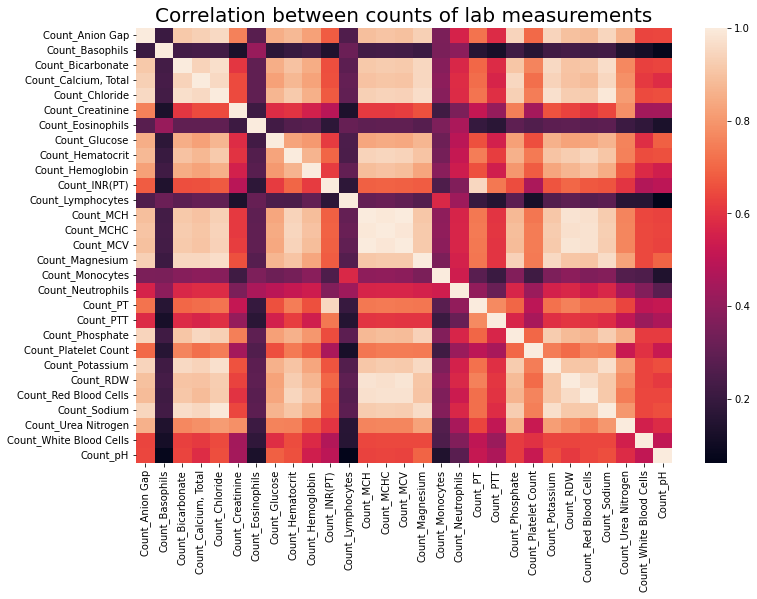

In [131]:
Count_measures = [column for column in df.columns.tolist() if column.startswith('Count_')]

corr_mat = np.corrcoef(df[Count_measures].values, rowvar=False)

f, ax = plt.subplots(figsize=(12, 8))

ax = sns.heatmap(corr_mat, annot=False, xticklabels=Count_measures, yticklabels=Count_measures)
ax.set_title("Correlation between counts of lab measurements", fontsize=20)

In [113]:
#model = GaussianNB()
regex = re.compile(r"\[|\]|<", re.IGNORECASE)
model = XGBClassifier(eval_metric='mlogloss')
df.columns = [regex.sub("_", col) if any(x in str(col) for x in set(('[', ']', '<'))) else col for col in df.columns.values]

# Prediction Features
X = df.drop(columns=['CHANCE_OF_READMISSION'])
# Target Variable- LOS
y = df['CHANCE_OF_READMISSION']


<AxesSubplot:xlabel='CHANCE_OF_READMISSION', ylabel='count'>

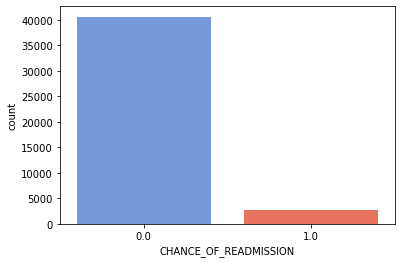

In [146]:
sns.countplot(df.CHANCE_OF_READMISSION)

In [114]:
smt= SMOTE()
X_smt, y_smt = smt.fit_resample(X, y)
print(Counter(y_smt))

Counter({0.0: 40612, 1.0: 40612})


In [115]:
X_train, X_test, y_train, y_test = train_test_split(X_smt, 
                                                    y_smt, 
                                                    test_size = .20, 
                                                    random_state = 0)


model.fit(X_train, y_train)
    
# Make predictions with model
y_pred = model.predict(X_test) 
print("accuracy:",metrics.accuracy_score(y_test, y_pred))
print("f1 score:",metrics.f1_score(y_test, y_pred, average='micro')) 
print ("precision:",metrics.precision_score(y_test, y_pred, average='macro') )
print ("recall:",metrics.recall_score(y_test, y_pred, average='macro') )

accuracy: 0.965958756540474
f1 score: 0.965958756540474
precision: 0.967204673104069
recall: 0.9664388556561845


In [155]:
df_cv = X_smt.join(y_smt, how="outer")
df_cv.head()

,SUBJECT_ID,HADM_ID,LOS,1Y_PRIOR_ADM,GENDER,ADMSNT_EMERGENCY,INSR_Government,INSR_Medicaid,INSR_Medicare,INSR_Private,...,Var_Phosphate,Var_Platelet Count,Var_Potassium,Var_RDW,Var_Red Blood Cells,Var_Sodium,Var_Urea Nitrogen,Var_White Blood Cells,Var_pH,CHANCE_OF_READMISSION
0,3,145834,10.784722,0.0,1,1,0,0,1,0,...,50970.0,51265.0,50971.0,51277.0,51279.0,50983.0,51006.0,51301.0,51155.5,0.0
1,4,185777,7.759028,0.0,0,1,0,0,0,1,...,50970.0,51265.0,50971.0,51277.0,51279.0,50983.0,51006.0,51301.0,51155.5,0.0
2,9,150750,4.881250,0.0,1,1,0,1,0,0,...,50970.0,51265.0,50971.0,51277.0,51279.0,50983.0,51006.0,51301.0,51155.5,0.0
3,11,194540,25.529167,0.0,0,1,0,0,0,1,...,50970.0,51265.0,50971.0,51277.0,51279.0,50983.0,51006.0,51301.0,51155.5,0.0
4,13,143045,6.855556,0.0,0,1,0,1,0,0,...,50970.0,51265.0,50971.0,51277.0,51279.0,50983.0,51006.0,51301.0,51155.5,0.0


Model: decision_tree
Accuracy: 0.822
Precision: 0.934
Recall: 0.782
F1-score: 0.846
AUC: 0.822

Model: random_forest
Accuracy: 0.861
Precision: 0.879
Recall: 0.843
F1-score: 0.859
AUC: 0.931

Model: balanced_random_forest
Accuracy: 0.841
Precision: 0.881
Recall: 0.819
F1-score: 0.847
AUC: 0.912

Model: adaboost_random_sampling
Accuracy: 0.853
Precision: 0.930
Recall: 0.857
F1-score: 0.884
AUC: 0.815

Model: xg_boost
Accuracy: 0.619
Precision: 0.934
Recall: 0.603
F1-score: 0.701
AUC: 0.917



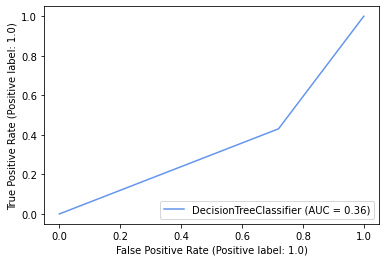

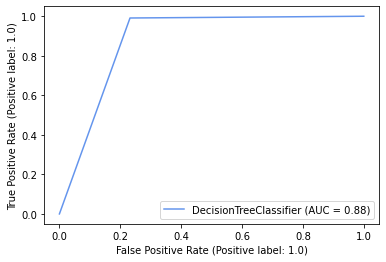

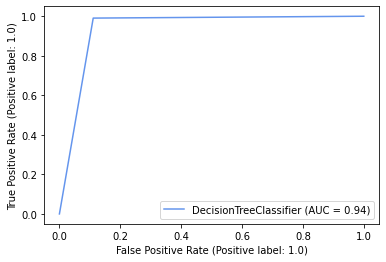

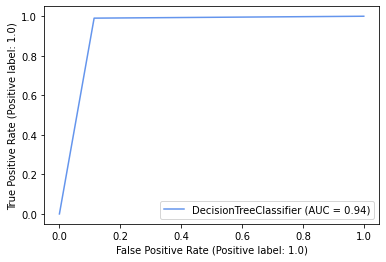

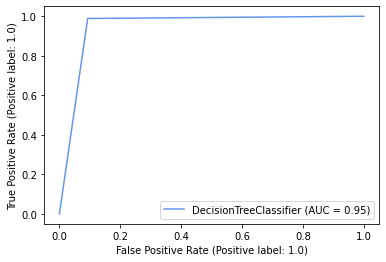

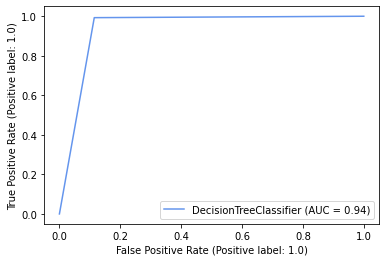

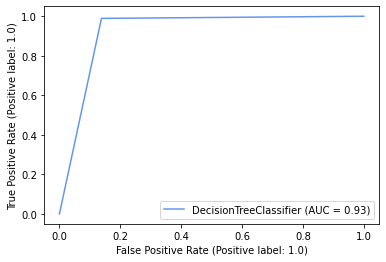

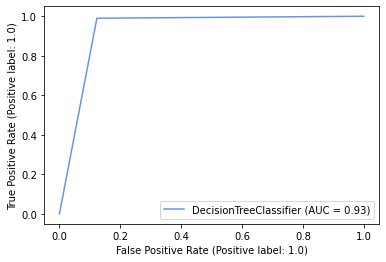

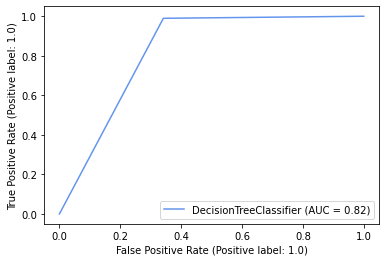

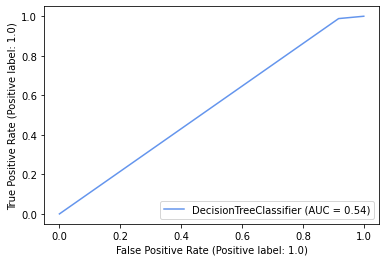

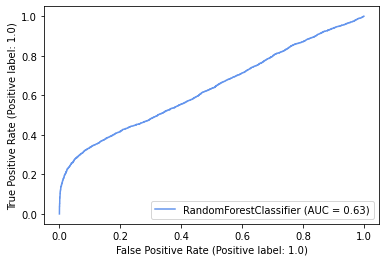

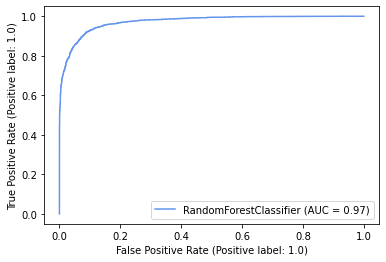

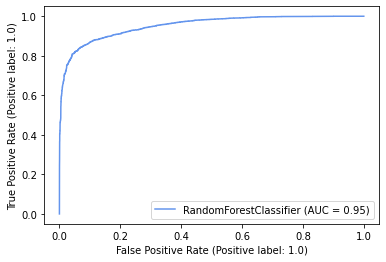

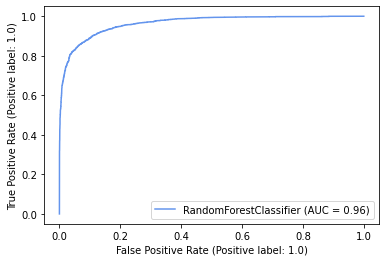

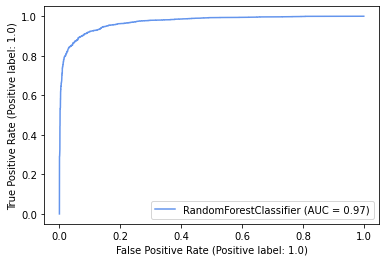

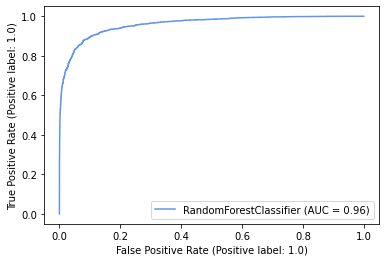

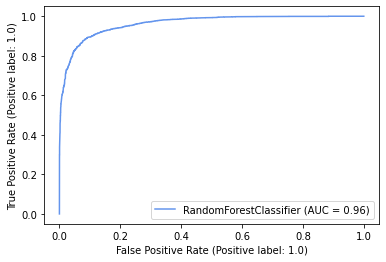

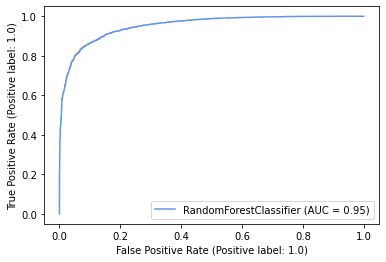

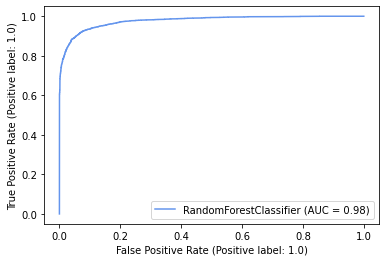

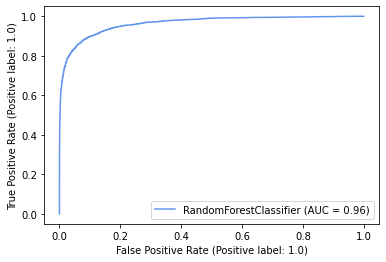

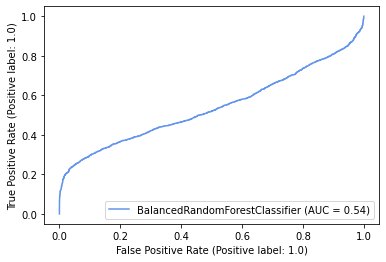

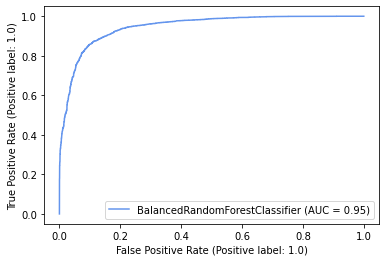

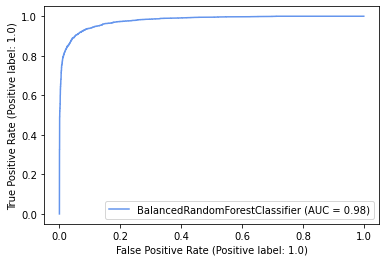

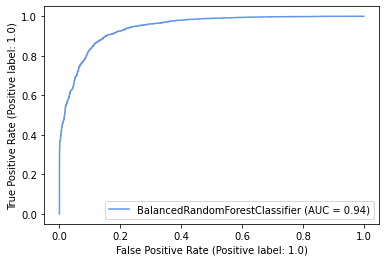

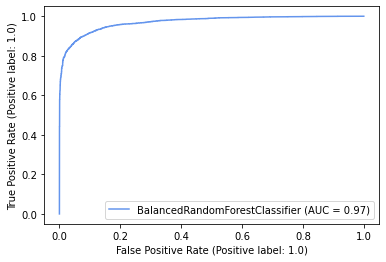

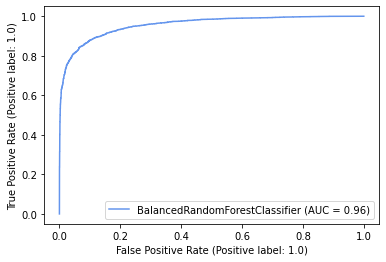

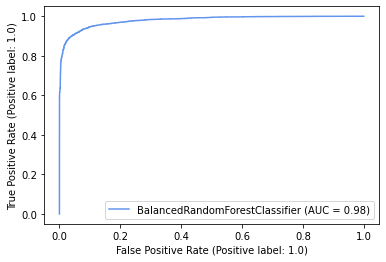

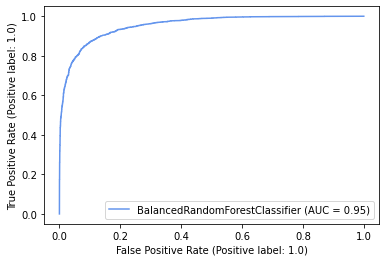

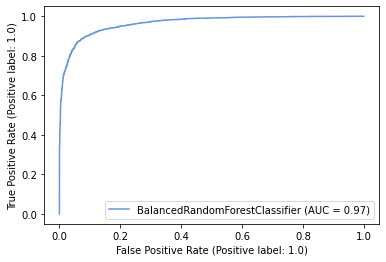

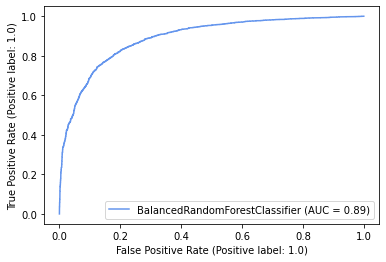

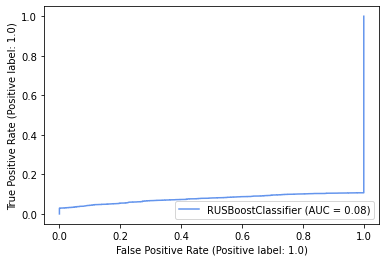

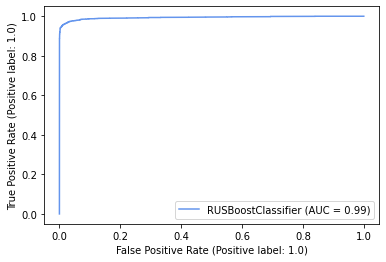

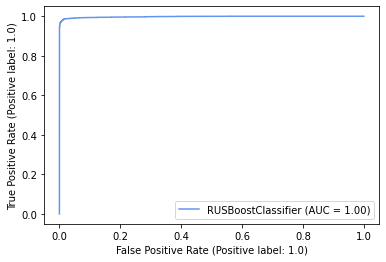

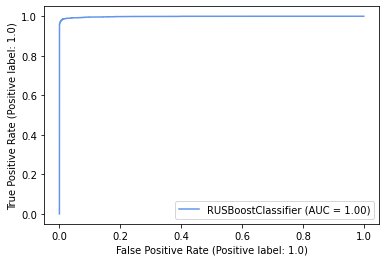

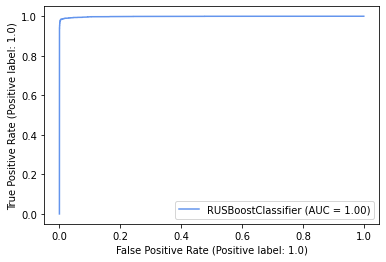

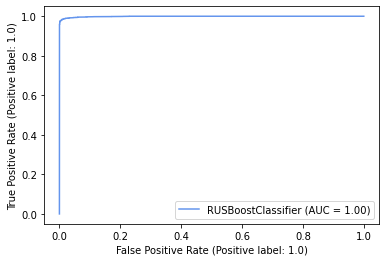

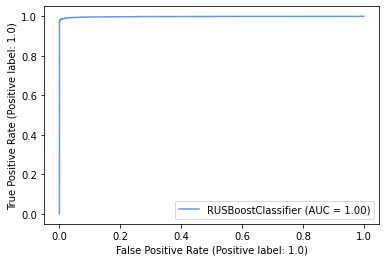

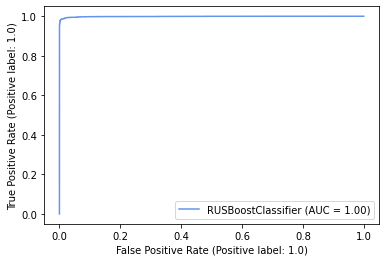

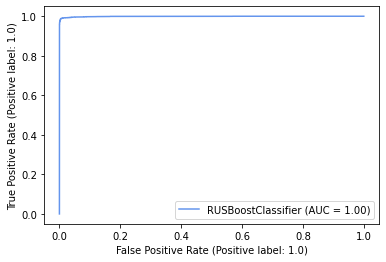

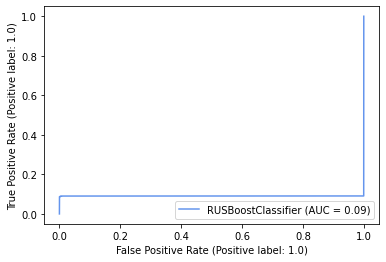

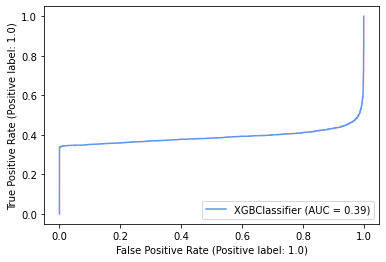

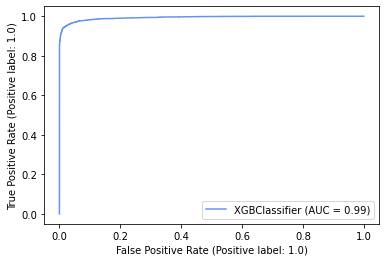

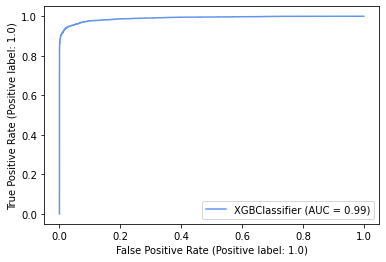

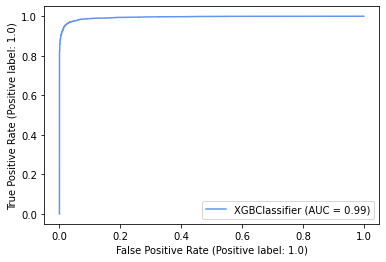

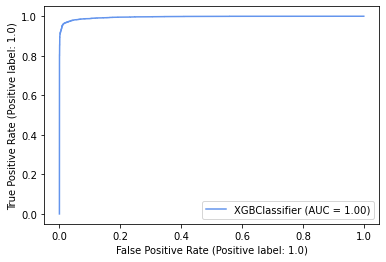

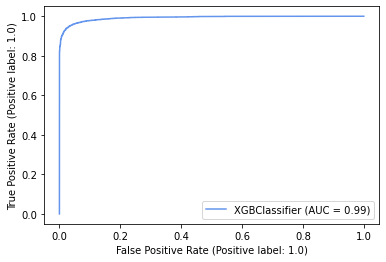

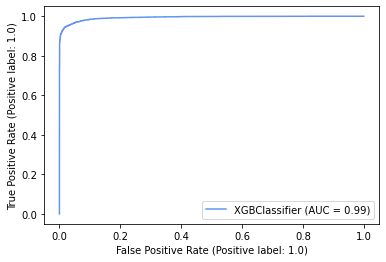

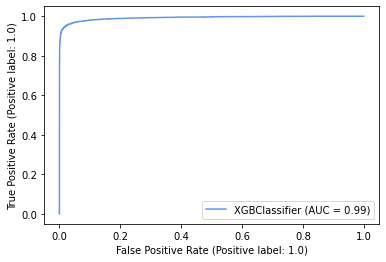

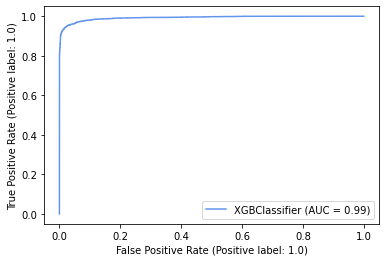

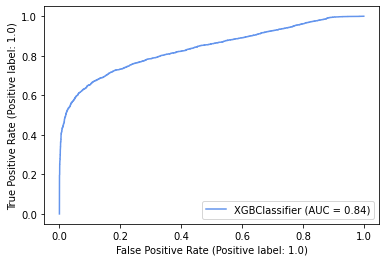

In [161]:
buildAndEvaluateModel(df_cv)

In [164]:
pip install fairmlhealth

Note: you may need to restart the kernel to use updated packages.


Model: xg_boost
Accuracy: 0.966
Precision: 0.937
Recall: 0.996
F1-score: 0.965
AUC: 0.983



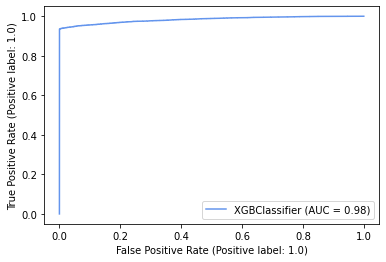

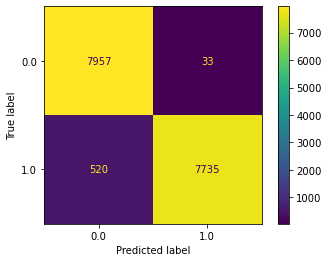

In [196]:
buildAndEvaluateModelFinal(df_cv)